## Prepare Notebook

In [1]:
import pandas as pd
import numpy as np
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
excel_path = r"../../static/mock/AntiBio2.xlsx"

In [3]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df_compounds = tables_dict["CompoundsData"]['dataframe']
df_bacterias = tables_dict["BacteriasData"]['dataframe']
df_experiments = tables_dict["ExperimentsData"]['dataframe']


worksheet name: Table
tables in worksheet: 0

worksheet name: CompoundsData
tables in worksheet: 1
table name: CompoundsData

worksheet name: BacteriasData
tables in worksheet: 1
table name: BacteriasData

worksheet name: ExperimentsData
tables in worksheet: 1
table name: ExperimentsData

worksheet name: Legend-Main
tables in worksheet: 0

worksheet name: Bac
tables in worksheet: 0


In [4]:
df_experiments.columns

Index(['REE', 'Bacteria', 'Salt/Solution', 'Stunting diameter'], dtype='object')

In [5]:
df_compounds.columns

Index(['REE', 'Ionic radii RE (salt)', 'X', 'Electronegativity (Oganov)',
       'Electronegativity (Malliken)', 'Electronegativity (Paulling)',
       'Crystal structure type (salt)', 'RE-O(H2O) (solution)',
       'RE-O(NO3) (solution)', 'Coordination number RE-O(H2O) (solution)',
       'Coordination number RE-O(NO3) (solution)', 'рН (solution)',
       'Nitrate complexes stability constant (solution)',
       'Electronic structure RE3+', 'Price'],
      dtype='object')

In [6]:
df_bacterias.columns

Index(['Name', 'Gram-stain (bacteria)', 'Wall thickness min (bacteria)',
       'Wall thickness max (bacteria)', 'Wall structure (bacteria)',
       'Wall composition 1 (bacteria)', 'Wall composition 2 (bacteria)',
       'Outer membrane (bacteria)', 'Membrane pore diameter min (bacteria)',
       'Membrane pore diameter max (bacteria)', 'Proteins (bacteria)',
       'Penicillin sensitivity (bacteria)', 'Cell layers (bacteria)'],
      dtype='object')

In [7]:
df = df_experiments.merge(df_compounds, left_on='REE', right_on='REE').merge(df_bacterias, left_on='Bacteria', right_on='Name')
df.head().columns

Index(['REE', 'Bacteria', 'Salt/Solution', 'Stunting diameter',
       'Ionic radii RE (salt)', 'X', 'Electronegativity (Oganov)',
       'Electronegativity (Malliken)', 'Electronegativity (Paulling)',
       'Crystal structure type (salt)', 'RE-O(H2O) (solution)',
       'RE-O(NO3) (solution)', 'Coordination number RE-O(H2O) (solution)',
       'Coordination number RE-O(NO3) (solution)', 'рН (solution)',
       'Nitrate complexes stability constant (solution)',
       'Electronic structure RE3+', 'Price', 'Name', 'Gram-stain (bacteria)',
       'Wall thickness min (bacteria)', 'Wall thickness max (bacteria)',
       'Wall structure (bacteria)', 'Wall composition 1 (bacteria)',
       'Wall composition 2 (bacteria)', 'Outer membrane (bacteria)',
       'Membrane pore diameter min (bacteria)',
       'Membrane pore diameter max (bacteria)', 'Proteins (bacteria)',
       'Penicillin sensitivity (bacteria)', 'Cell layers (bacteria)'],
      dtype='object')

In [8]:
df.dtypes

REE                                                 object
Bacteria                                            object
Salt/Solution                                        int64
Stunting diameter                                    int64
Ionic radii RE (salt)                              float64
X                                                  float64
Electronegativity (Oganov)                         float64
Electronegativity (Malliken)                       float64
Electronegativity (Paulling)                       float64
Crystal structure type (salt)                        int64
RE-O(H2O) (solution)                               float64
RE-O(NO3) (solution)                               float64
Coordination number RE-O(H2O) (solution)           float64
Coordination number RE-O(NO3) (solution)           float64
рН (solution)                                      float64
Nitrate complexes stability constant (solution)    float64
Electronic structure RE3+                           obje

## Utilities

In [9]:
import shap 
artifacts_path = "../../static/mock/antibio_artifacts/"
def explain(model, X, name="model", is_save=False, color_bar=False):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, plot_size=[10, 6], s=26, show=False, color_bar=color_bar)
    if is_save:
        plt.tick_params(axis='both', labelsize=16)
        plt.savefig(f'{artifacts_path}{name} shap.png', bbox_inches='tight')
        plt.show()

In [10]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


In [11]:
def draw_importance(importances, model_name, columns, is_save=False):
    features = {}
    color1 = "#2D466D"
    color2 = "#A2B0C5"
    for i, feature in enumerate(columns):
        features[f"f{i+1}"] = feature

    indices = np.argsort(importances)[::-1]
    num_to_plot = len(columns)
    feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

    print("Feature ranking:")
    for f in range(num_to_plot):
        print(
            "%d. %s %f "
            % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
        )
    plt.figure(figsize=(25, 12))
    bars = plt.bar(
        range(num_to_plot),
        importances[indices[:num_to_plot]],
        color=get_color_gradient(color1, color2, num_to_plot),
        align="center",
    )
    ax = plt.gca()
    plt.xticks(range(num_to_plot), range(1, num_to_plot+1), fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlim([-1, num_to_plot])
    plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices], fontsize="20")
    ax.set_xlabel("Feature rank", fontsize=22)
    ax.set_ylabel("Contribution to prediction", fontsize=22)
    # plt.title(f"Feature importance in {model_name}")
    if is_save:
        plt.savefig(f'../mock/{model_name}.svg', format='svg', dpi=600, bbox_inches='tight', pad_inches=0)
    

### Models runners

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 

In [19]:
def run_rforest(X, y, is_show_params=True):
    parameters = {
    'n_estimators': range(50, 1000, 50),
    'max_depth': [None] + list(range(1, 15, 1))}

    model = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_percentage_error'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    scores = {}
    print("MAE: ", -clf.best_score_)
    scores['MAE'] = -clf.best_score_
    if is_show_params:
        print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    scores['R2'] = clf.cv_results_['mean_test_r2'].max()
    print("MSE: ", -clf.cv_results_['mean_test_neg_mean_squared_error'].max())
    scores['MSE'] = -clf.cv_results_['mean_test_neg_mean_squared_error'].max()
    print("EVS: ", clf.cv_results_['mean_test_explained_variance'].max())
    scores['EVS'] = clf.cv_results_['mean_test_explained_variance'].max()
    print("MAPE: ", clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'].max())
    return best_model, scores

In [20]:
def run_gradient_boosting(X, y, is_show_params=True):
    parameters = {
    'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators': [2, 4, 8, 16, 32, 64, 100, 200, 300, 400],
    'max_depth': range(1, 18, 1)}

    model = GradientBoostingRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_percentage_error'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    scores = {}
    print("MAE: ", -clf.best_score_)
    scores['MAE'] = -clf.best_score_
    if is_show_params:
        print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    scores['R2'] = clf.cv_results_['mean_test_r2'].max()
    print("MSE: ", -clf.cv_results_['mean_test_neg_mean_squared_error'].max())
    scores['MSE'] = -clf.cv_results_['mean_test_neg_mean_squared_error'].max()
    print("EVS: ", clf.cv_results_['mean_test_explained_variance'].max())
    scores['EVS'] = clf.cv_results_['mean_test_explained_variance'].max()
    print("MAPE: ", clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'].max())
    return best_model, scores

In [21]:
def run_xgboost(X, y, is_show_params=True):
    parameters = {
        'min_child_weight': [1, 5, 7, 10, 11, 12, 15,],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 5],
        'subsample': [0.4, 0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_percentage_error'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    scores = {}
    print("MAE: ", -clf.best_score_)
    scores['MAE'] = -clf.best_score_
    if is_show_params:
        print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    scores['R2'] = clf.cv_results_['mean_test_r2'].max()
    print("MSE: ", -clf.cv_results_['mean_test_neg_mean_squared_error'].max())
    scores['MSE'] = -clf.cv_results_['mean_test_neg_mean_squared_error'].max()
    print("EVS: ", clf.cv_results_['mean_test_explained_variance'].max())
    scores['EVS'] = clf.cv_results_['mean_test_explained_variance'].max()
    print("MAPE: ", clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'].max())
    return best_model, scores

## Data exploration

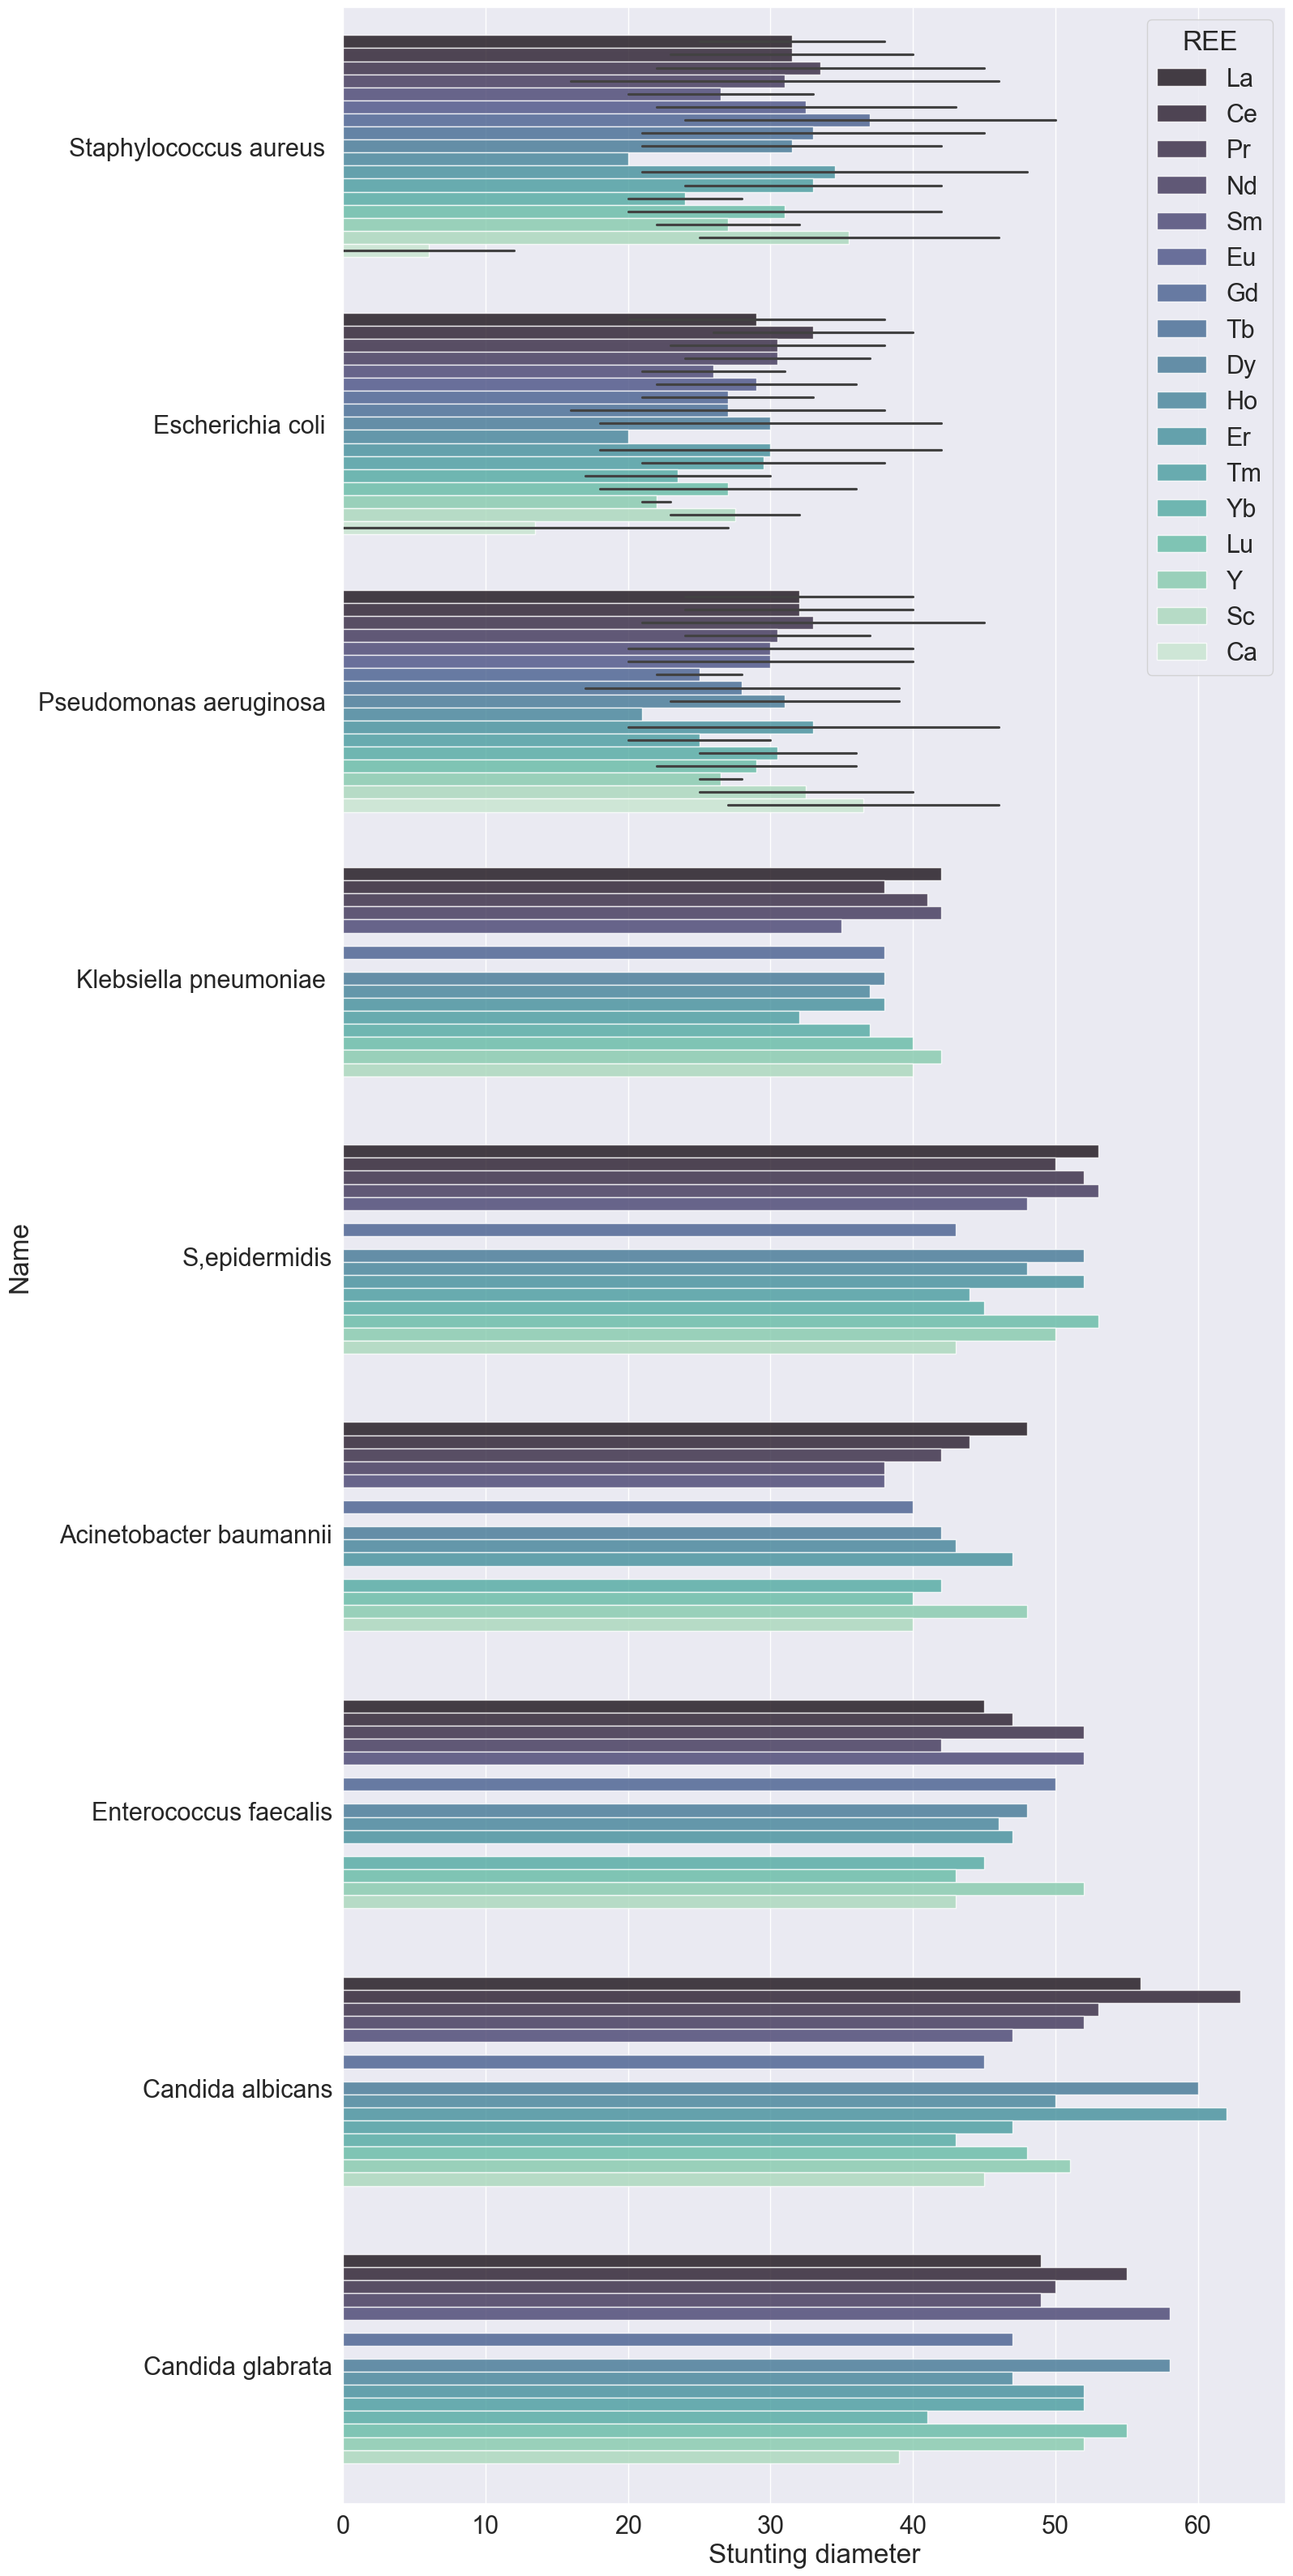

In [18]:
plt.figure(figsize=(15, 40))
sns.set(font_scale=2)
sns.barplot(data=df, y='Name', x='Stunting diameter', hue='REE', palette='mako', orient='h', alpha=0.8)
plt.savefig(f'../mock/Stunting diameter bars.svg', format='svg', dpi=600, bbox_inches='tight', transparent="True", pad_inches=0)

In [19]:
slice = df[['Name', 'REE', 'Stunting diameter', 'Salt/Solution']]
idx = slice.groupby(['Name'])['Stunting diameter'].transform(max) == df['Stunting diameter']
slice[idx].sort_values('Stunting diameter', ascending=False).reset_index(drop=True).to_csv("../mock/state.csv")

/var/folders/68/6ycxy_mj2b7660jm9rmwjtlm0000gn/T/ipykernel_43916/3595817399.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = slice.groupby(['Name'])['Stunting diameter'].transform(max) == df['Stunting diameter']


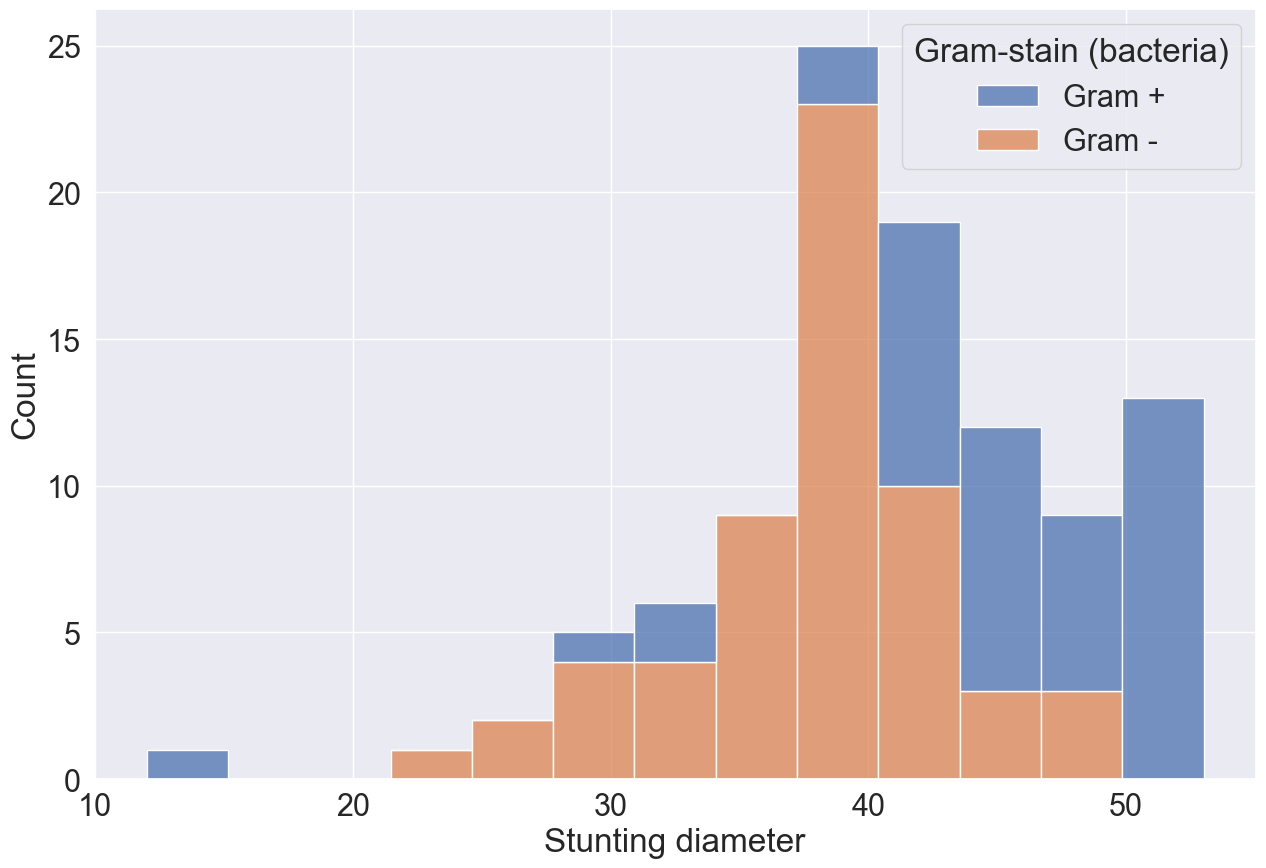

In [20]:
df_renamed = df.copy(deep=True)
df_renamed.replace({'Gram-stain (bacteria)': {1: 'Gram +', -1: 'Gram -'}}, inplace=True)
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
sns.histplot(data=df_renamed[df['Salt/Solution'] == 1], x='Stunting diameter', hue='Gram-stain (bacteria)', multiple='stack')
plt.savefig(f'../mock/Gram-stain hover.svg', format='svg', dpi=600, bbox_inches='tight', pad_inches=0)

<Axes: xlabel='Stunting diameter', ylabel='Count'>

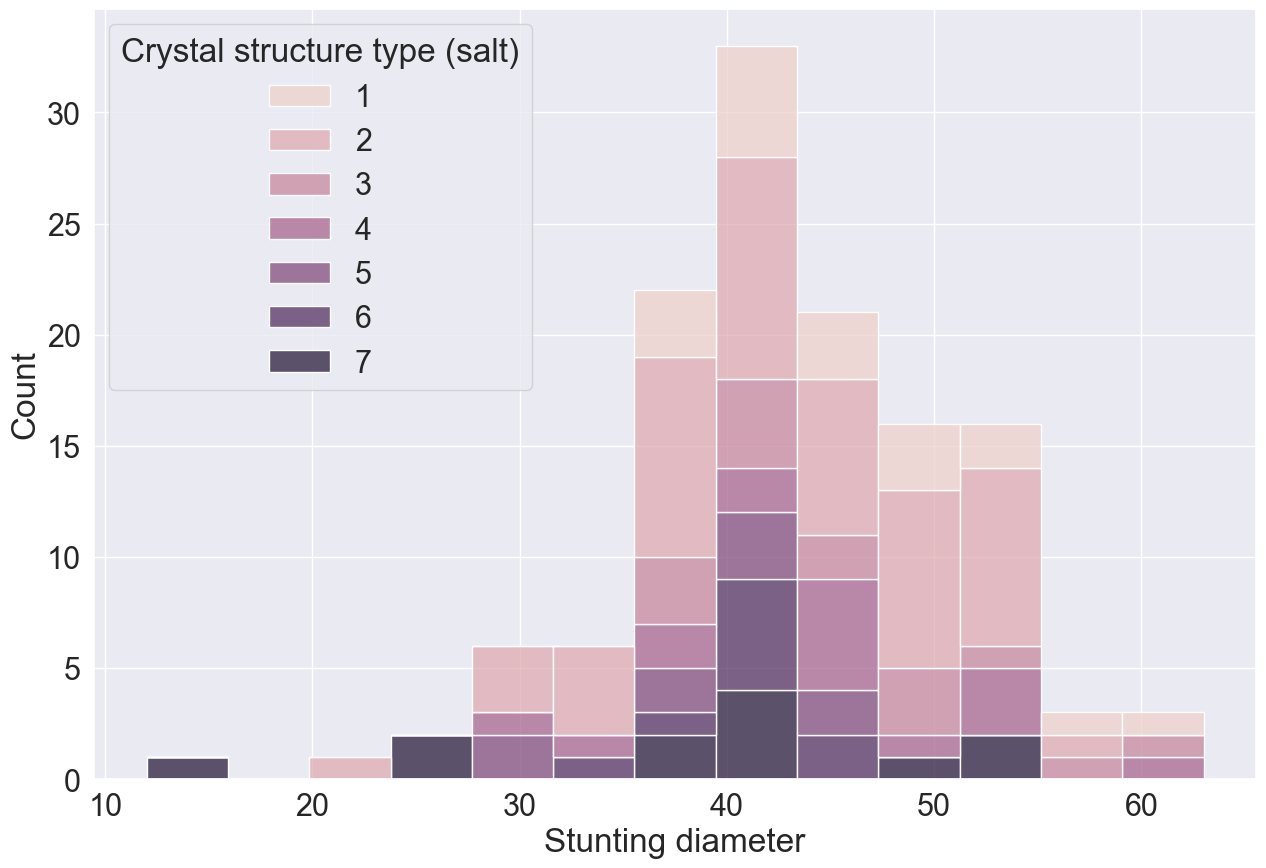

In [21]:
df_renamed = df.copy(deep=True)
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
sns.histplot(data=df_renamed[df['Salt/Solution'] == 1], x='Stunting diameter', hue='Crystal structure type (salt)', multiple='stack')

<Axes: xlabel='Stunting diameter', ylabel='Count'>

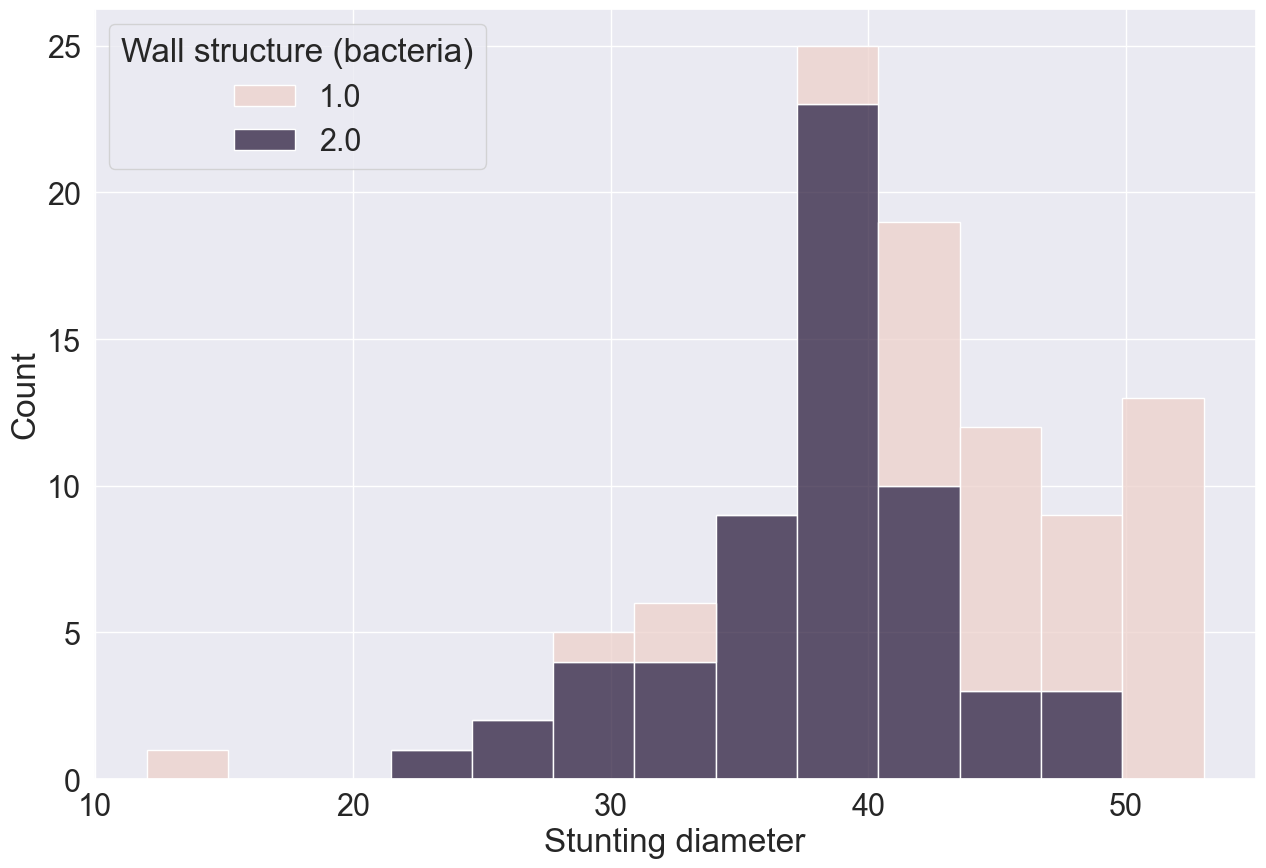

In [22]:
df_renamed = df.copy(deep=True)
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
sns.histplot(data=df_renamed[df['Salt/Solution'] == 1], x='Stunting diameter', hue='Wall structure (bacteria)', multiple='stack')

In [23]:
df.columns

Index(['REE', 'Bacteria', 'Salt/Solution', 'Stunting diameter',
       'Ionic radii RE (salt)', 'X', 'Electronegativity (Oganov)',
       'Electronegativity (Malliken)', 'Electronegativity (Paulling)',
       'Crystal structure type (salt)', 'RE-O(H2O) (solution)',
       'RE-O(NO3) (solution)', 'Coordination number RE-O(H2O) (solution)',
       'Coordination number RE-O(NO3) (solution)', 'рН (solution)',
       'Nitrate complexes stability constant (solution)',
       'Electronic structure RE3+', 'Price', 'Name', 'Gram-stain (bacteria)',
       'Wall thickness min (bacteria)', 'Wall thickness max (bacteria)',
       'Wall structure (bacteria)', 'Wall composition 1 (bacteria)',
       'Wall composition 2 (bacteria)', 'Outer membrane (bacteria)',
       'Membrane pore diameter min (bacteria)',
       'Membrane pore diameter max (bacteria)', 'Proteins (bacteria)',
       'Penicillin sensitivity (bacteria)', 'Cell layers (bacteria)'],
      dtype='object')

<Axes: xlabel='Stunting diameter', ylabel='Count'>

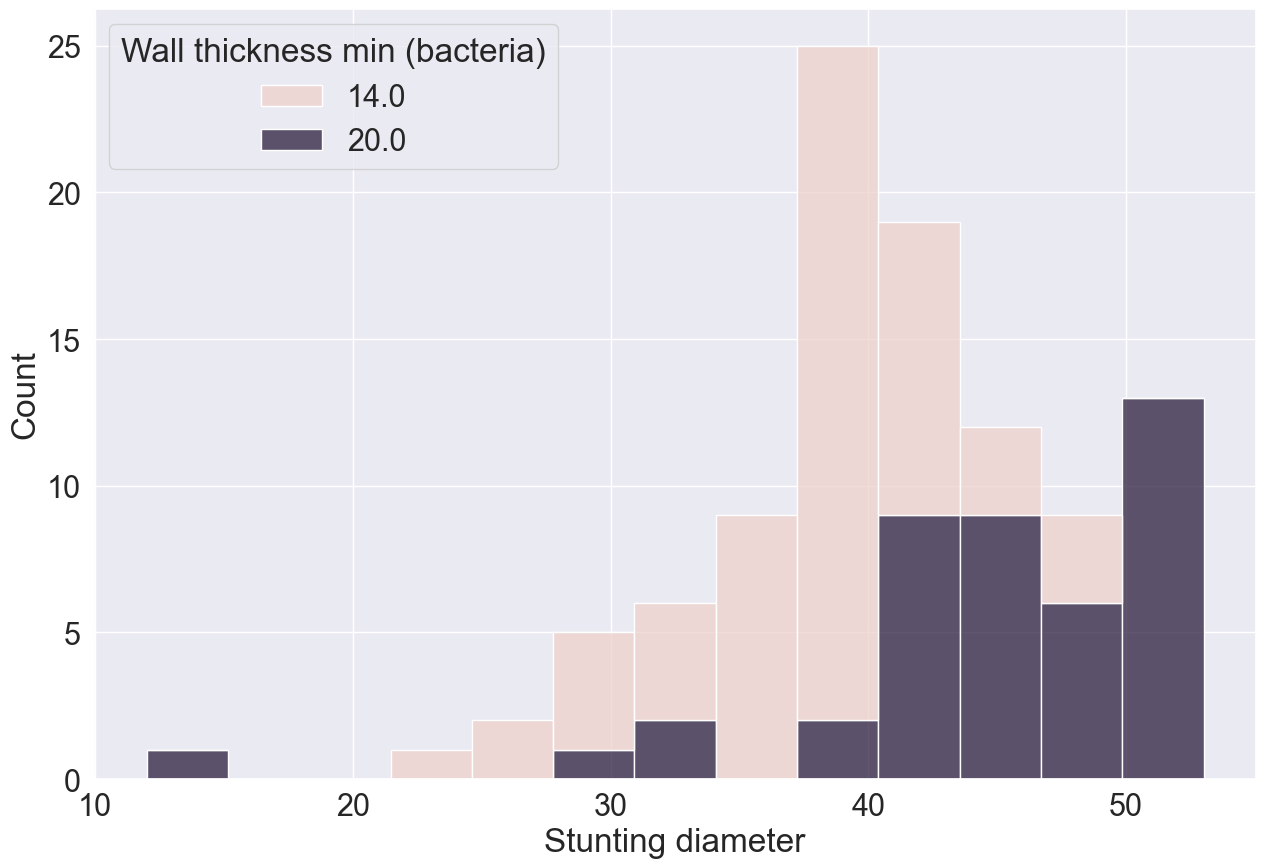

In [24]:
df_renamed = df.copy(deep=True)
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
sns.histplot(data=df_renamed[df['Salt/Solution'] == 1], x='Stunting diameter', hue='Wall thickness min (bacteria)', multiple='stack')

<Axes: xlabel='Stunting diameter', ylabel='Count'>

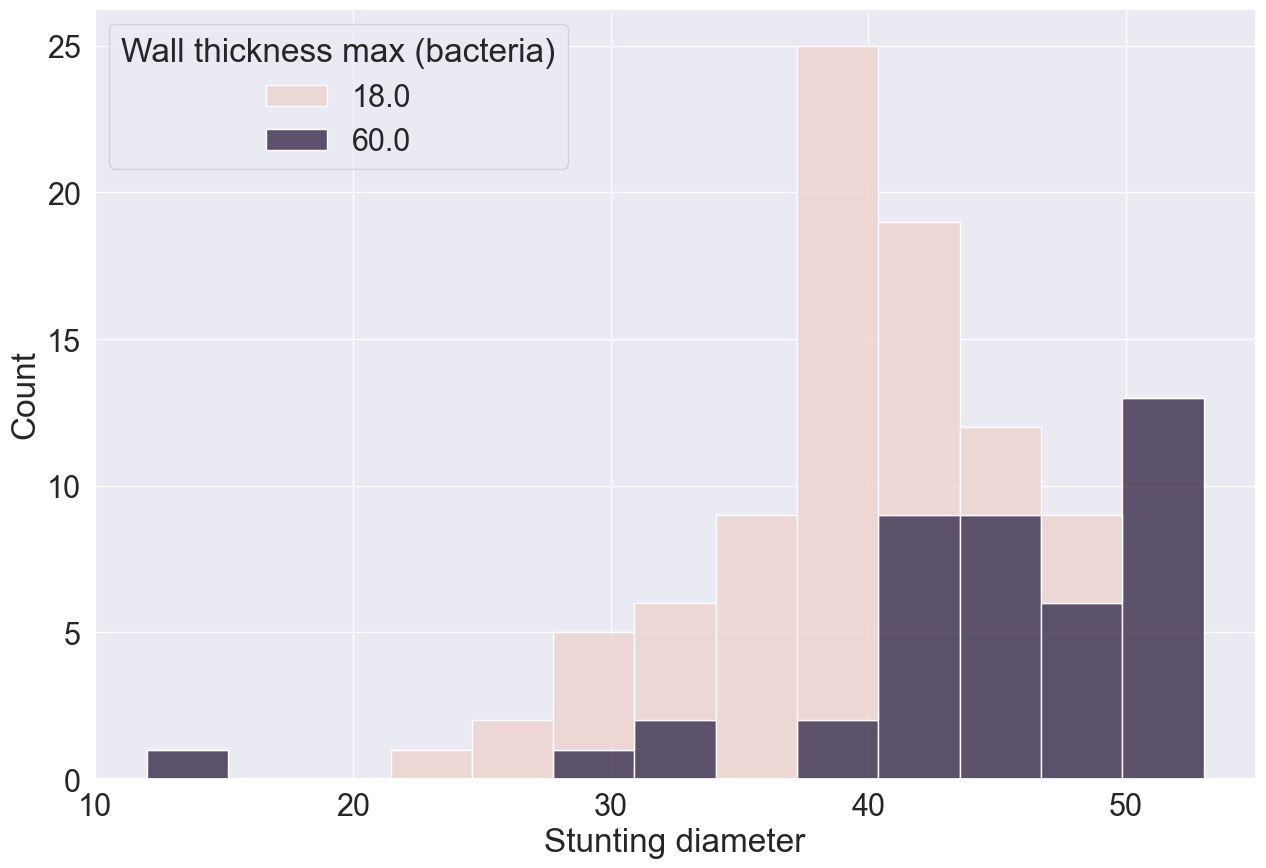

In [25]:
df_renamed = df.copy(deep=True)
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
sns.histplot(data=df_renamed[df['Salt/Solution'] == 1], x='Stunting diameter', hue='Wall thickness max (bacteria)', multiple='stack')

## Quike Electronegativity test

### Prepare for experiments

In [59]:
mixed_data = df[df['Salt/Solution'] == 1][['Stunting diameter', 'Ionic radii RE (salt)',
                                     'Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                     'Electronegativity (Paulling)', 'Crystal structure type (salt)']]
mixed_data

,Stunting diameter,Ionic radii RE (salt),Electronegativity (Oganov),Electronegativity (Malliken),Electronegativity (Paulling),Crystal structure type (salt)
1,38,1.03,2.49,3.06,1.10,1
3,40,1.01,2.61,3.05,1.12,1
5,45,0.99,2.24,3.21,1.13,2
7,46,0.98,2.11,3.72,1.14,2
9,33,0.96,1.90,2.90,1.17,2
...,...,...,...,...,...,...
176,52,0.88,2.03,3.61,1.25,4
177,41,0.87,1.78,3.12,1.10,5
178,55,0.86,2.68,2.89,1.27,7
179,52,0.90,2.52,3.26,1.22,2


In [60]:
X = mixed_data.drop('Stunting diameter', axis=1)
y = mixed_data['Stunting diameter']

### Random forest

In [15]:
best_random_forest_allen, _ = run_rforest(X, y)

MAE:  6.627490731737919
{'max_depth': 3, 'n_estimators': 550}
R2:  -0.8171817139561078
MSE:  66.47110657011547
EVS:  0.10760479112170022


Feature ranking:
1. Electronegativity (Paulling) 0.525210 
2. Electronegativity (Oganov) 0.160274 
3. Ionic radii RE (salt) 0.134561 
4. Electronegativity (Malliken) 0.118987 
5. Crystal structure type (salt) 0.060968 


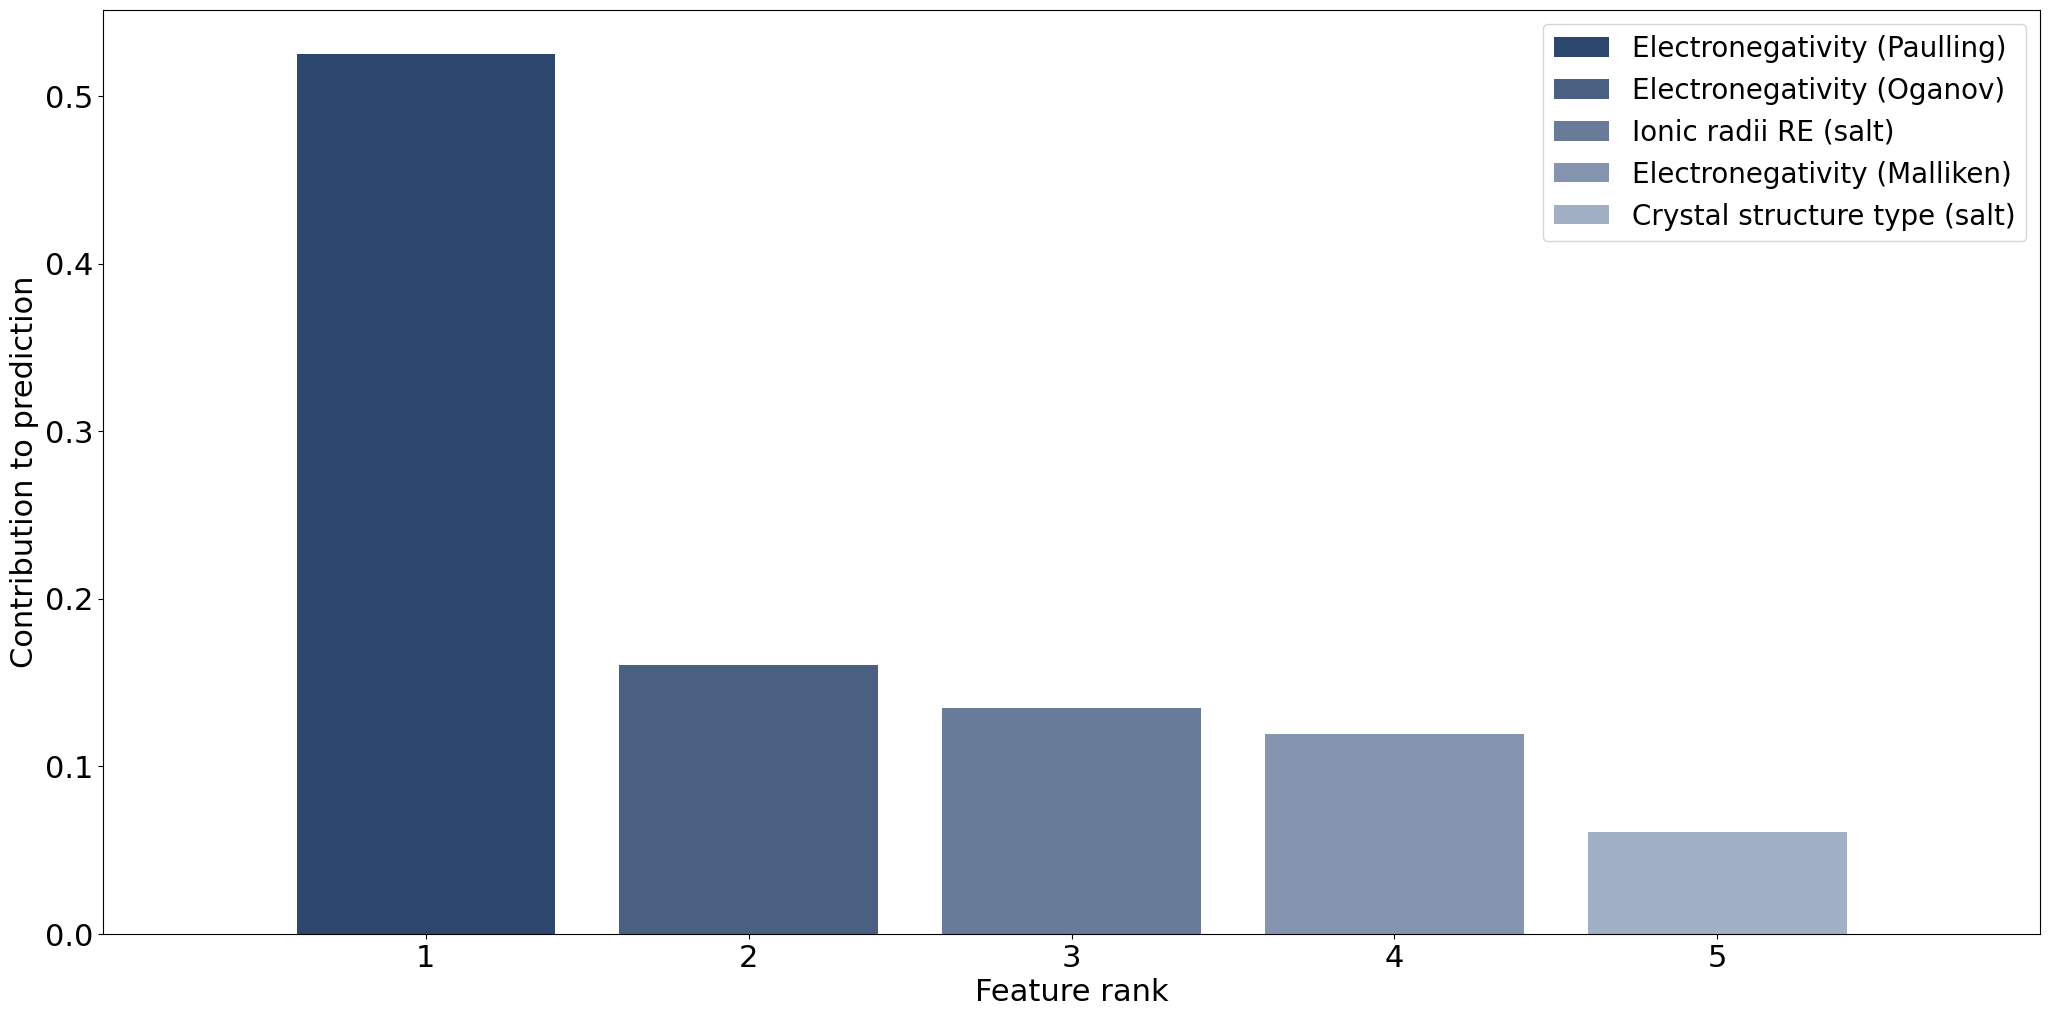

In [16]:
draw_importance(
    best_random_forest_allen.feature_importances_, 
    "Random forest elctrongativity",
    columns=X.columns,
    is_save=True
)

### Gradient boosting

In [44]:
best_gradient_boost_allen, _ = run_gradient_boosting(X, y)

MAE:  6.597279398941112
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 2}
R2:  -0.835906215808025
MSE:  66.9728729739015
EVS:  0.13367324495194013


Feature ranking:
1. Electronegativity (Paulling) 0.782973 
2. Crystal structure type (salt) 0.217027 
3. Electronegativity (Malliken) 0.000000 
4. Electronegativity (Oganov) 0.000000 
5. Ionic radii RE (salt) 0.000000 


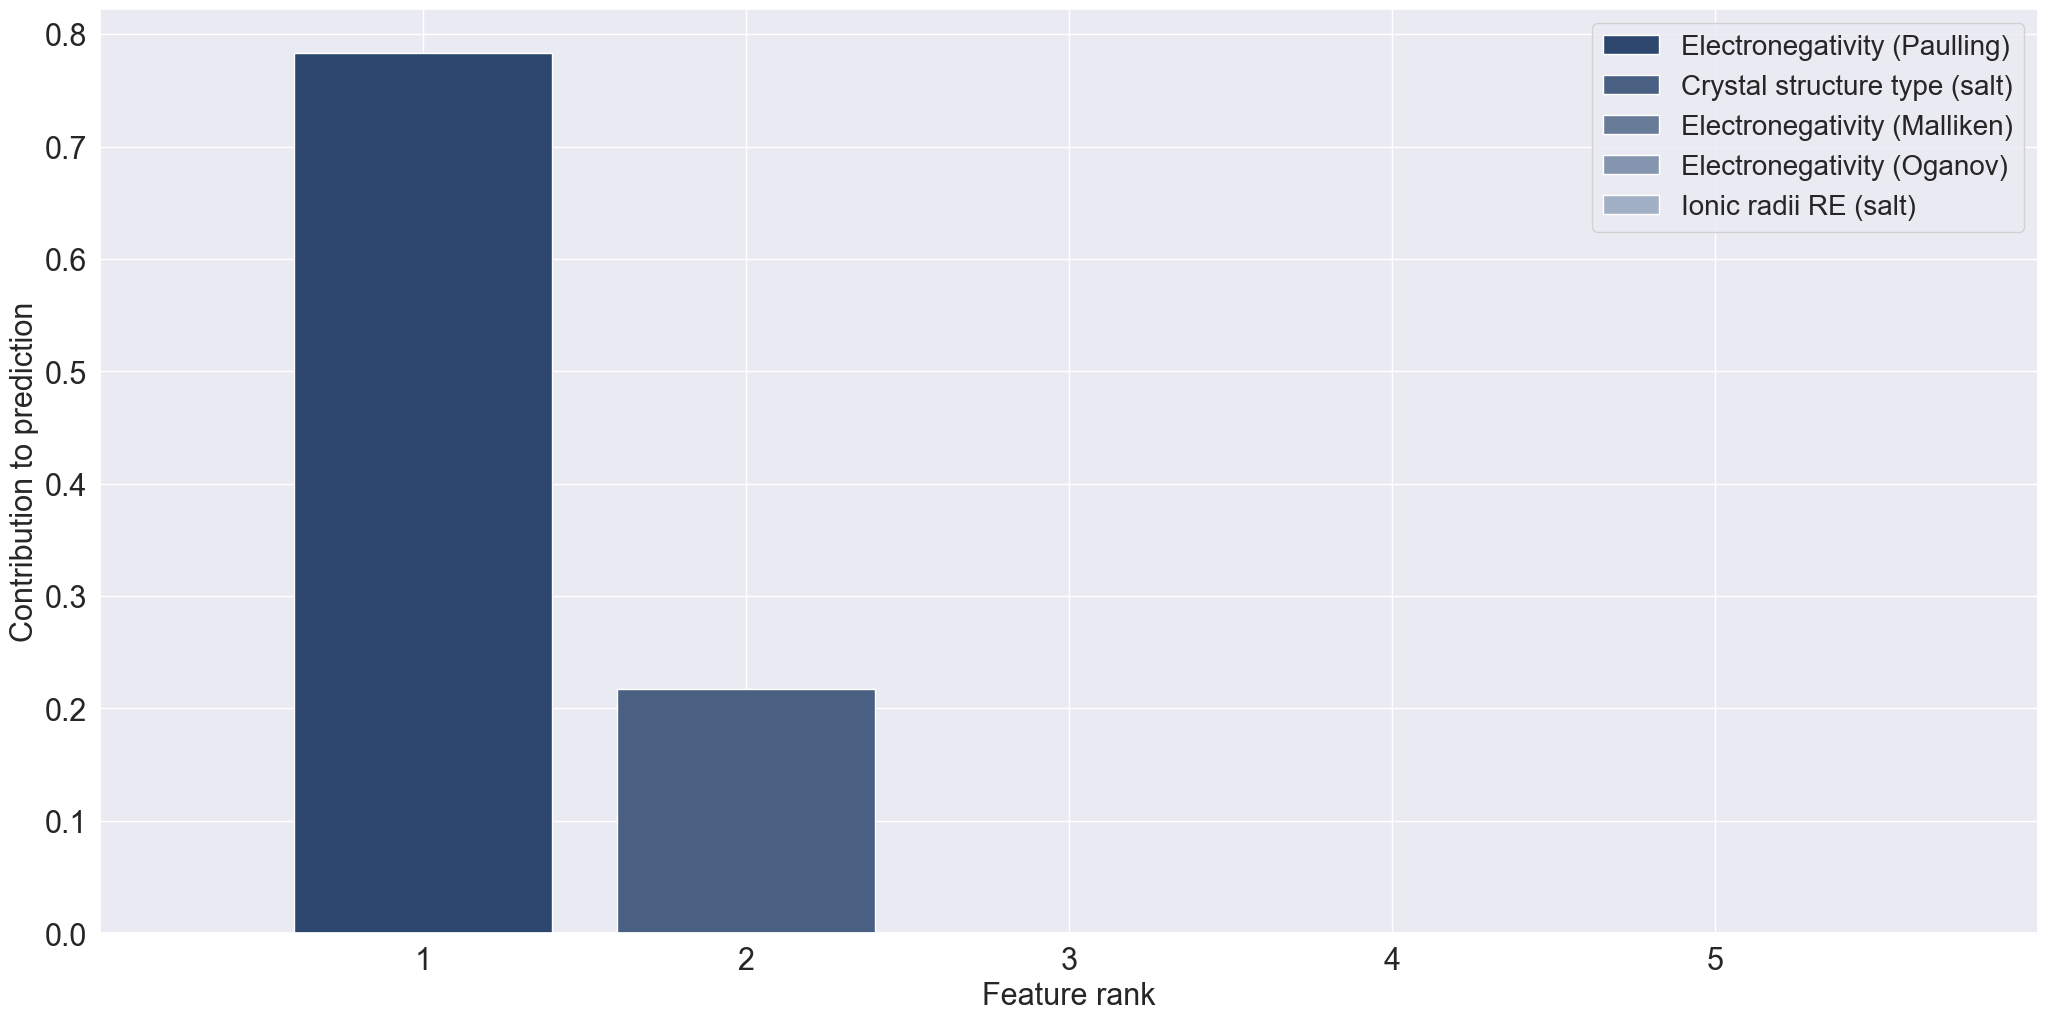

In [45]:
draw_importance(
    best_gradient_boost_allen.feature_importances_,
    "Gradient boosting elctrongativity",
    columns=X.columns,
    is_save=True
)

### XGBoost

In [46]:
best_xgboost_allen, _ = run_xgboost(X, y)

MAE:  6.6626788946298445
{'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.4}
R2:  -0.8399087067109612
MSE:  66.88129169230619
EVS:  0.10306003022770631


Feature ranking:
1. Crystal structure type (salt) 0.259114 
2. Electronegativity (Paulling) 0.199634 
3. Electronegativity (Malliken) 0.195918 
4. Electronegativity (Oganov) 0.184685 
5. Ionic radii RE (salt) 0.160649 


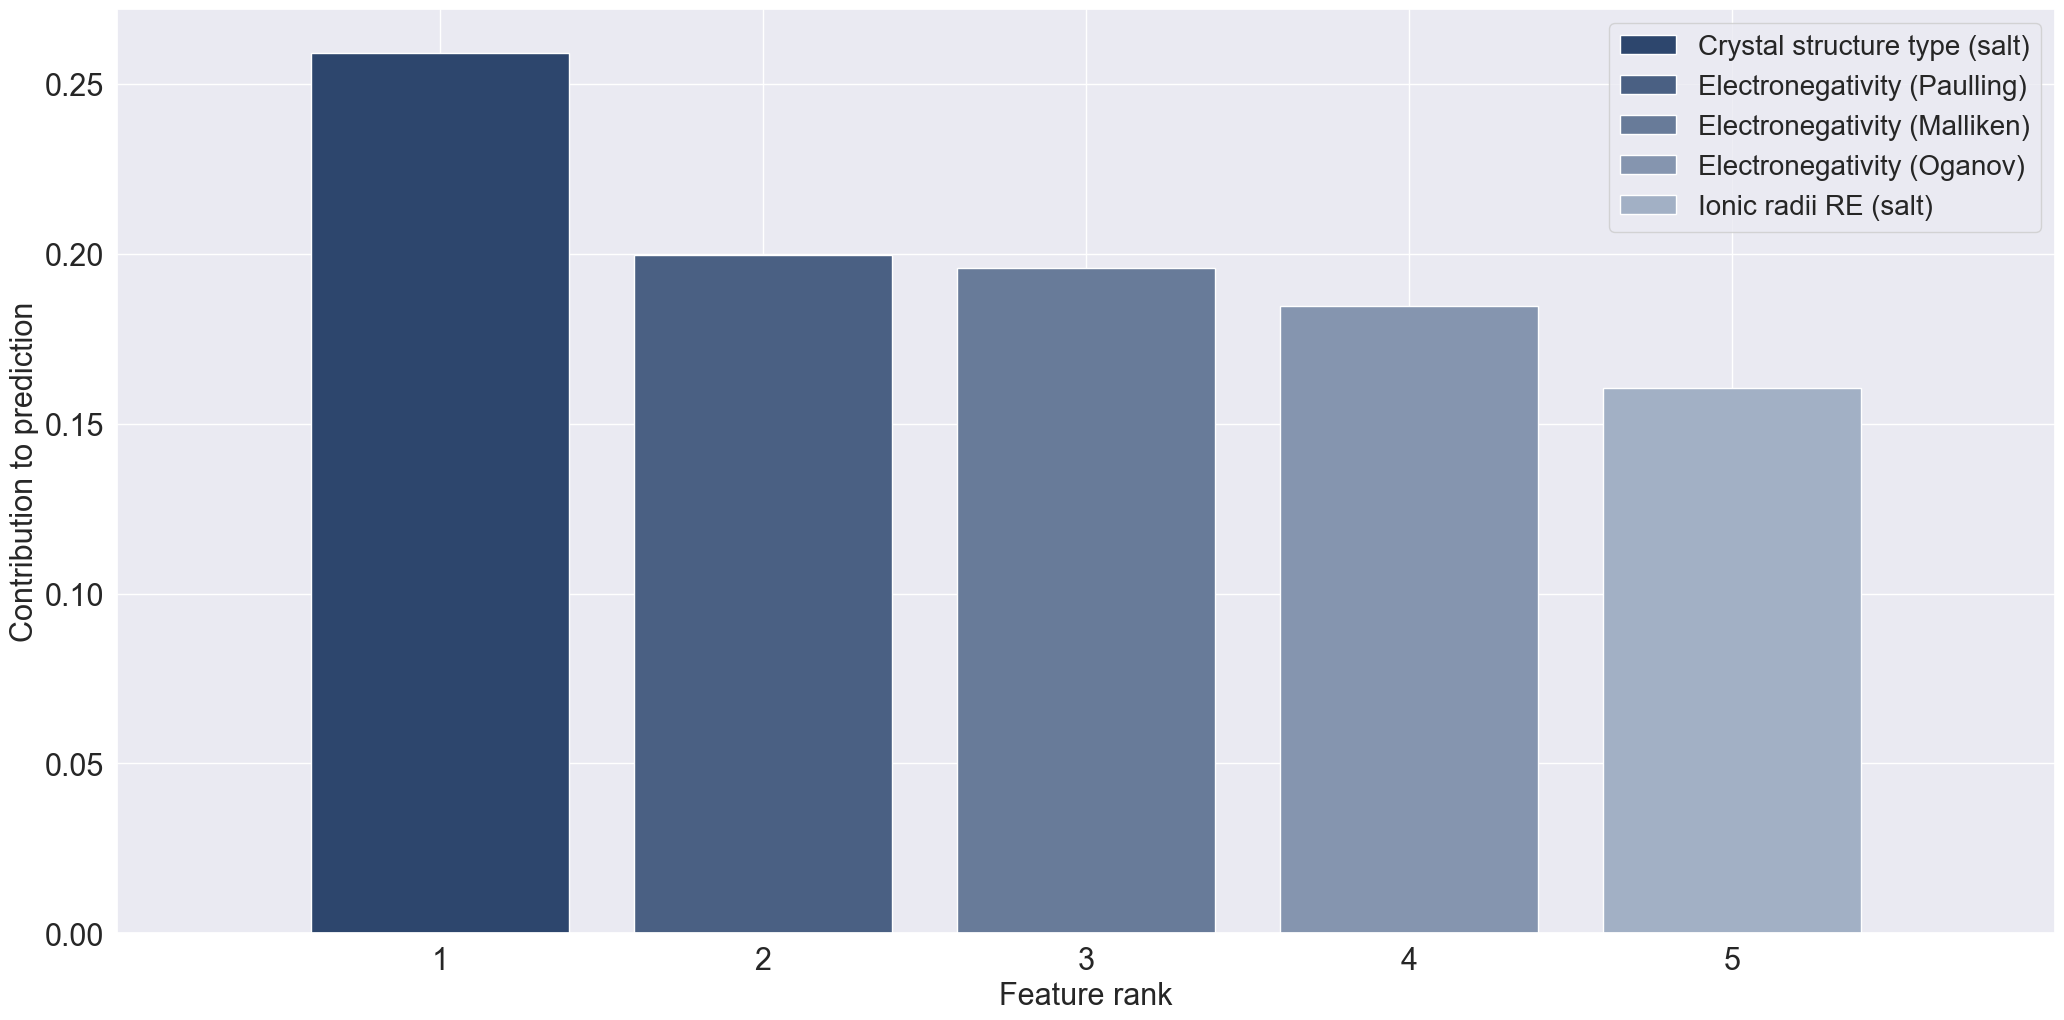

In [47]:
draw_importance(
    best_xgboost_allen.feature_importances_, 
    "XGboost",
    columns=X.columns,
    is_save=True
)

### Test MAE and R2 with different sets

In [48]:
X_oganov = X.drop(['Electronegativity (Malliken)', 'Electronegativity (Paulling)'], axis=1)
best_rf_oganov, _ = run_rforest(X_oganov, y)
best_gb_oganov, _ = run_gradient_boosting(X_oganov, y)
best_xgboost_oganov, _ = run_xgboost(X_oganov, y)

MAE:  6.631369361472805
{'max_depth': 3, 'n_estimators': 500}
R2:  -0.8305813293343125
MSE:  67.14264460258394
EVS:  0.12519993772106255
MAE:  6.6154665608002805
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 16}
R2:  -0.8403678122377377
MSE:  67.20445279709566
EVS:  0.1258444355923174
MAE:  6.676898486797626
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.4}
R2:  -0.8435661633348748
MSE:  67.19592456808739
EVS:  0.11772689247345243


In [49]:
X_malliken = X.drop(['Electronegativity (Oganov)', 'Electronegativity (Paulling)'], axis=1)
best_rf_malliken, _ = run_rforest(X_malliken, y)
best_gb_malliken, _ = run_gradient_boosting(X_malliken, y)
best_xgboost_malliken, _ = run_xgboost(X_malliken, y)

MAE:  6.609924262982053
{'max_depth': 3, 'n_estimators': 550}
R2:  -0.8133969858080136
MSE:  66.5155995076452
EVS:  0.10504156540031684
MAE:  6.583092092576527
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 16}
R2:  -0.8313610821653634
MSE:  66.8237589074549
EVS:  0.12792441415377698
MAE:  6.682102188697229
{'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5}
R2:  -0.8366766273089699
MSE:  66.90445080324176
EVS:  0.12638430313888283


In [50]:
X_poland = X.drop(['Electronegativity (Oganov)', 'Electronegativity (Malliken)'], axis=1)
best_rf_poland, _ = run_rforest(X_poland, y)
best_gb_poland, _ = run_gradient_boosting(X_poland, y)
best_xgboost_poland, _ = run_xgboost(X_poland, y)

MAE:  6.605083252405038
{'max_depth': 3, 'n_estimators': 500}
R2:  -0.8058983871242624
MSE:  66.15009271844107
EVS:  0.12987486337412846
MAE:  6.572290139288976
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 16}
R2:  -0.826820108287731
MSE:  66.70206689565212
EVS:  0.14365006549847023
MAE:  6.632536022479718
{'colsample_bytree': 0.4, 'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 1.0}
R2:  -0.8410819547453949
MSE:  67.469847369444
EVS:  0.09702311512101973


### Salts Matrix 

In [ ]:
from itertools import combinations
from tqdm import tqdm

en_col = ['Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                          'Electronegativity (Paulling)']
scores = {'MAE': [], 'R2': [], 'MSE': [], 'EVS': []}
en_col_combinations = []

for i in range(1, len(en_col) + 1):
    en_col_combinations += list(combinations(en_col, i))

for comb in tqdm(en_col_combinations):
    _, score = run_xgboost(X[list(comb)], y)
    for key in score:
        scores[key] += [score[key]]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:53<11:20, 113.39s/it]

MAE:  6.63777577326848
{'colsample_bytree': 0.4, 'gamma': 3, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
R2:  -0.8574537862111147
MSE:  67.94499311561712
EVS:  0.10379818105931507


 29%|██▊       | 2/7 [03:45<09:23, 112.64s/it]

MAE:  6.682336821922888
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
R2:  -0.8171277156979979
MSE:  66.3979304406722
EVS:  0.16055147604353256


KeyError: "None of [Index(['Electronegativity (Poland)'], dtype='object')] are in the [columns]"

### EN combinations with salts features 

In [61]:
from itertools import combinations
from tqdm import tqdm

en_col = ['Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                          'Electronegativity (Paulling)']
scores = {'MAE': [], 'R2': [], 'MSE': [], 'EVS': []}
en_col_combinations = []

for i in range(0, len(en_col) + 1):
    en_col_combinations += list(combinations(en_col, i))

for comb in tqdm(en_col_combinations):
    print(list(comb))
    d = list(comb)
    _, score = run_xgboost(X.drop(d, axis=1), y, is_show_params=False)
    for key in score:
        scores[key] += [score[key]]

  0%|          | 0/8 [00:00<?, ?it/s]

[]


 12%|█▎        | 1/8 [02:03<14:26, 123.85s/it]

MAE:  6.6626788946298445
R2:  -0.8399087067109612
MSE:  66.88129169230619
EVS:  0.10306003022770631
['Electronegativity (Oganov)']


 25%|██▌       | 2/8 [04:00<11:58, 119.81s/it]

MAE:  6.6476440576406635
R2:  -0.834817507685645
MSE:  66.75841418299925
EVS:  0.09895408298610928
['Electronegativity (Malliken)']


 38%|███▊      | 3/8 [05:58<09:53, 118.74s/it]

MAE:  6.665064503596378
R2:  -0.8468563187498631
MSE:  67.25081764905923
EVS:  0.09419848126422678
['Electronegativity (Paulling)']


 50%|█████     | 4/8 [07:57<07:56, 119.01s/it]

MAE:  6.672265287546011
R2:  -0.837788197844902
MSE:  66.85052145808275
EVS:  0.10817201429779195
['Electronegativity (Oganov)', 'Electronegativity (Malliken)']


 62%|██████▎   | 5/8 [09:47<05:47, 115.85s/it]

MAE:  6.632536022479718
R2:  -0.8410819547453949
MSE:  67.469847369444
EVS:  0.09702311512101973
['Electronegativity (Oganov)', 'Electronegativity (Paulling)']


 75%|███████▌  | 6/8 [11:36<03:46, 113.40s/it]

MAE:  6.682102188697229
R2:  -0.8366766273089699
MSE:  66.90445080324176
EVS:  0.12638430313888283
['Electronegativity (Malliken)', 'Electronegativity (Paulling)']


 88%|████████▊ | 7/8 [13:22<01:50, 110.79s/it]

MAE:  6.676898486797626
R2:  -0.8435661633348748
MSE:  67.19592456808739
EVS:  0.11772689247345243
['Electronegativity (Oganov)', 'Electronegativity (Malliken)', 'Electronegativity (Paulling)']


100%|██████████| 8/8 [15:01<00:00, 112.72s/it]

MAE:  6.6279307145338775
R2:  -0.8286335818396393
MSE:  66.8442618990872
EVS:  0.12431154487211142


## Solutions Electronegativity

In [56]:
solutions_mixed = df[df['Salt/Solution'] == 0][['Stunting diameter', 'Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                          'Electronegativity (Paulling)', 'RE-O(H2O) (solution)', 'RE-O(NO3) (solution)',
                                          'Coordination number RE-O(H2O) (solution)',
                                          'Coordination number RE-O(NO3) (solution)', 'рН (solution)', 'Nitrate complexes stability constant (solution)']]

In [57]:
X = solutions_mixed.drop('Stunting diameter', axis=1)
y = solutions_mixed['Stunting diameter']

In [19]:
best_xgboost_solutionsen, _ = run_xgboost(X, y)

MAE:  3.3058927466652612
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.4}
R2:  -0.3329861221571187
MSE:  37.9043946123082
EVS:  0.0064808992529277855


Feature ranking:
1. рН (solution) 0.133736 
2. Nitrate complexes stability constant (solution) 0.129675 
3. Electronegativity (Oganov) 0.122409 
4. Coordination number RE-O(H2O) (solution) 0.116375 
5. Electronegativity (Paulling) 0.107507 
6. Electronegativity (Malliken) 0.104923 
7. Coordination number RE-O(NO3) (solution) 0.100041 
8. RE-O(H2O) (solution) 0.093941 
9. RE-O(NO3) (solution) 0.091392 


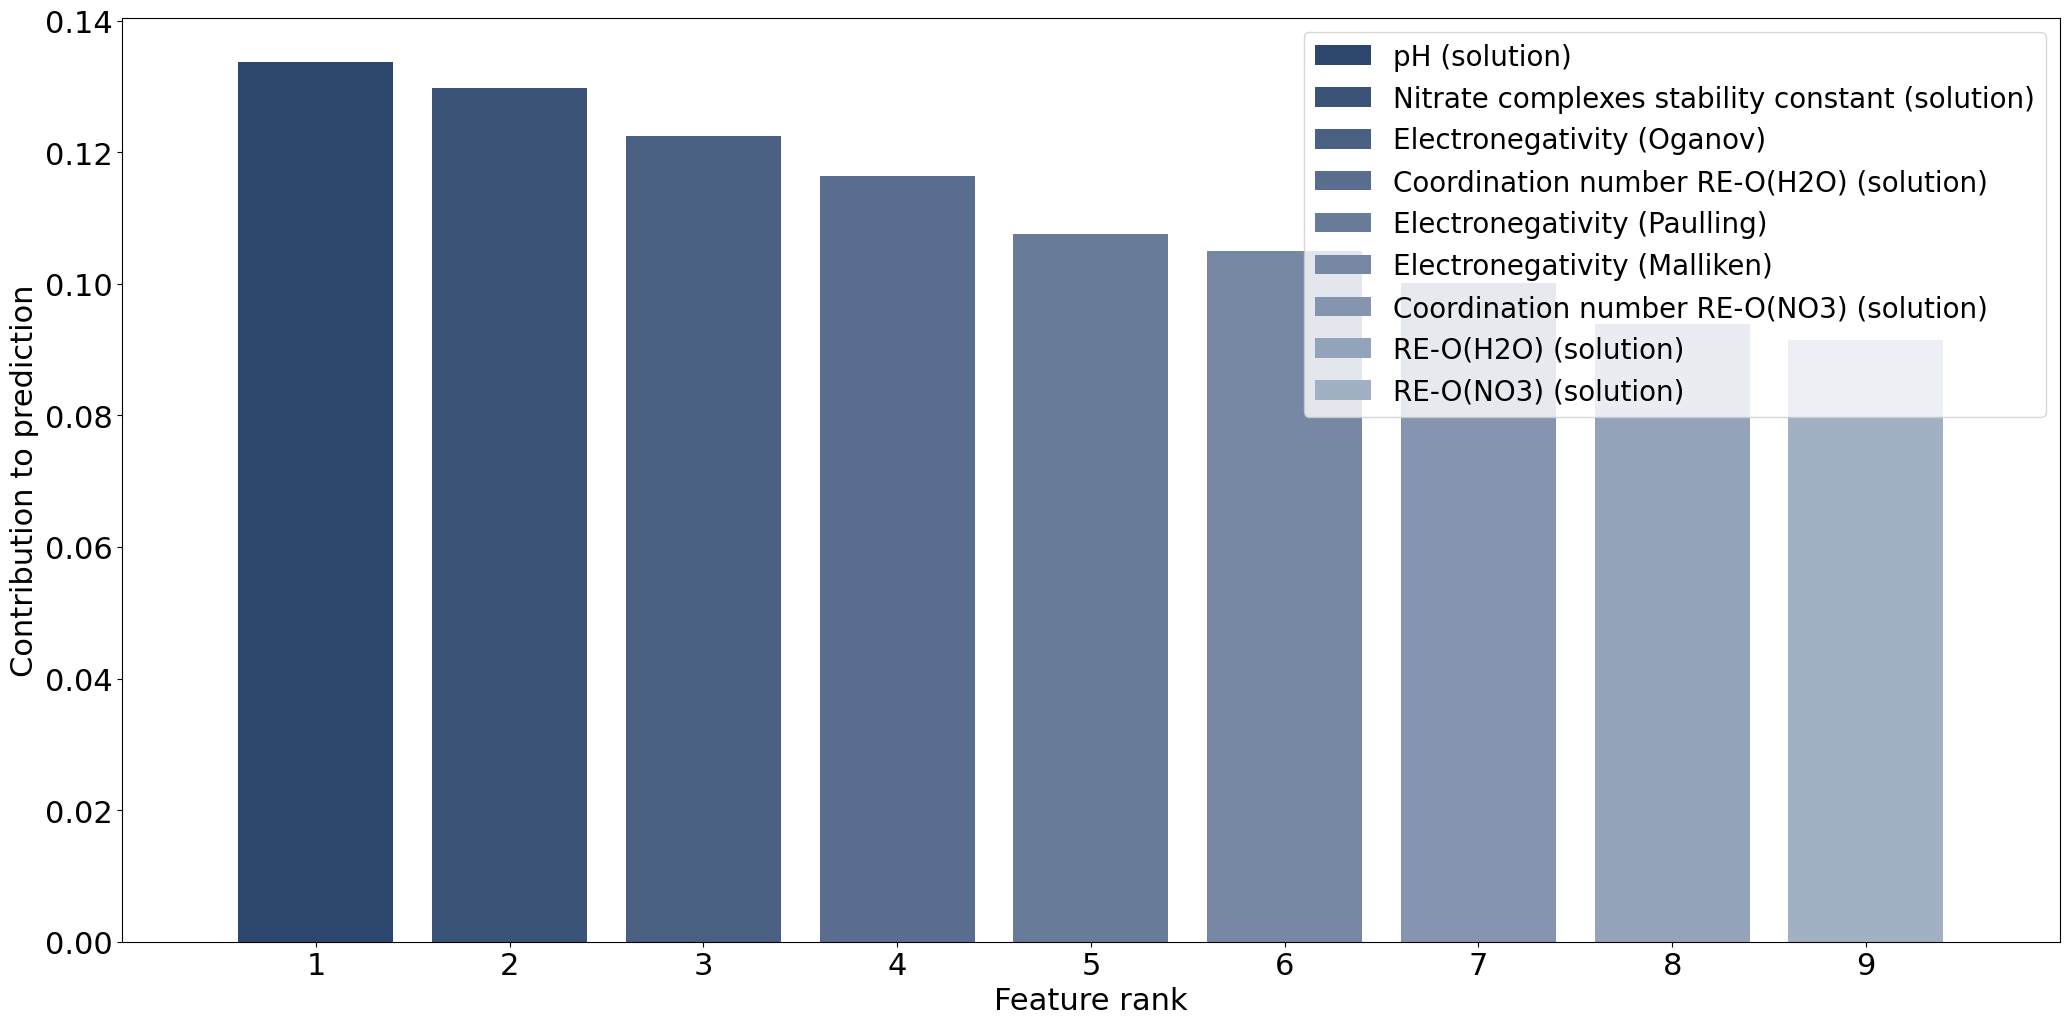

In [26]:
draw_importance(
    best_xgboost_solutionsen.feature_importances_, 
    "XGboost solutions en",
    columns=X.columns,
    is_save=True
)

In [56]:
X_oganov = X.drop(['Electronegativity (Malliken)', 'Electronegativity (Paulling)'], axis=1)
X_malliken = X.drop(['Electronegativity (Oganov)', 'Electronegativity (Paulling)'], axis=1)
X_poland = X.drop(['Electronegativity (Oganov)', 'Electronegativity (Malliken)'], axis=1)
best_xgboost_oganov, _ = run_xgboost(X_oganov, y)
best_xgboost_malliken, _ = run_xgboost(X_malliken, y)
best_xgboost_poland, _ = run_xgboost(X_poland, y)

MAE:  3.283936396512118
{'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.4}
R2:  -0.3422277871427515
MSE:  37.9043946123082
EVS:  8.881784197001253e-17
MAE:  3.319052425731312
{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.4}
R2:  -0.34422557701635925
MSE:  37.9043946123082
EVS:  8.881784197001253e-17
MAE:  3.3142261401089756
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.4}
R2:  -0.3382205022517501
MSE:  37.9043946123082
EVS:  0.0037950179969121534


In [ ]:
from itertools import combinations

en_col = ['Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                          'Electronegativity (Paulling)']
scores = {'MAE': [], 'R2': [], 'MSE': [], 'EVS': []}
en_col_combinations = []

for i in range(1, len(en_col) + 1):
    en_col_combinations += list(combinations(en_col, i))

for comb in en_col_combinations:
    print(comb)
    _, score = run_xgboost(X[list(comb)], y)
    for key in score:
        scores[key] += [score[key]]

('Electronegativity, Oganov',)
MAE:  3.2725036690451885
{'colsample_bytree': 0.4, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.4}
R2:  -0.37929214084738283
MSE:  37.9043946123082
EVS:  8.881784197001253e-17
('Electronegativity, Malliken',)
MAE:  3.3314045854048295
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.5}
R2:  -0.3944013556252905
MSE:  37.9043946123082
EVS:  0.030357660541885222
('Electronegativity, Poland',)
MAE:  3.3212748059359463
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 1.0}
R2:  -0.3814031782262409
MSE:  37.9043946123082
EVS:  0.01369033831550659
('Electronegativity, Oganov', 'Electronegativity, Malliken')
MAE:  3.2963834901289504
{'colsample_bytree': 1.0, 'gamma': 3, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.4}
R2:  -0.3748992930177368
MSE:  37.9043946123082
EVS:  0.0036227536186659746
('Electronegativity, Oganov', 'Electronegativity, Poland

### EN combinations with solutions features 

In [58]:
from itertools import combinations
from tqdm import tqdm

en_col = ['Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                          'Electronegativity (Paulling)']
scores = {'MAE': [], 'R2': [], 'MSE': [], 'EVS': []}
en_col_combinations = []

for i in range(0, len(en_col) + 1):
    en_col_combinations += list(combinations(en_col, i))

for comb in tqdm(en_col_combinations):
    print(list(comb))
    d = list(comb)
    _, score = run_xgboost(X.drop(d, axis=1), y, is_show_params=False)
    for key in score:
        scores[key] += [score[key]]

  0%|          | 0/8 [00:00<?, ?it/s]

[]


 12%|█▎        | 1/8 [01:53<13:13, 113.33s/it]

MAE:  3.3058927466652612
R2:  -0.3329861221571187
MSE:  37.9043946123082
EVS:  0.0064808992529277855
['Electronegativity (Oganov)']


 25%|██▌       | 2/8 [03:38<10:50, 108.38s/it]

MAE:  3.3204766845703118
R2:  -0.3299081604362179
MSE:  37.9043946123082
EVS:  0.005477632261504439
['Electronegativity (Malliken)']


 38%|███▊      | 3/8 [05:22<08:53, 106.72s/it]

MAE:  3.2984058900312947
R2:  -0.347659092597629
MSE:  37.9043946123082
EVS:  0.0012271113265006183
['Electronegativity (Paulling)']


 50%|█████     | 4/8 [07:08<07:04, 106.17s/it]

MAE:  3.3004401363026004
R2:  -0.3464273992892698
MSE:  37.9043946123082
EVS:  0.0003156332623781788
['Electronegativity (Oganov)', 'Electronegativity (Malliken)']


 62%|██████▎   | 5/8 [08:48<05:11, 103.98s/it]

MAE:  3.3142261401089756
R2:  -0.3382205022517501
MSE:  37.9043946123082
EVS:  0.0037950179969121534
['Electronegativity (Oganov)', 'Electronegativity (Paulling)']


 75%|███████▌  | 6/8 [10:30<03:26, 103.48s/it]

MAE:  3.319052425731312
R2:  -0.34422557701635925
MSE:  37.9043946123082
EVS:  8.881784197001253e-17
['Electronegativity (Malliken)', 'Electronegativity (Paulling)']


 88%|████████▊ | 7/8 [12:12<01:43, 103.02s/it]

MAE:  3.283936396512118
R2:  -0.3422277871427515
MSE:  37.9043946123082
EVS:  8.881784197001253e-17
['Electronegativity (Oganov)', 'Electronegativity (Malliken)', 'Electronegativity (Paulling)']


100%|██████████| 8/8 [13:50<00:00, 103.83s/it]

MAE:  3.303121122880415
R2:  -0.3490019904119513
MSE:  37.9043946123082
EVS:  8.881784197001253e-17


## Bacterias properties salts

In [32]:
bacterias_data = df[df['Salt/Solution'] == 1][['Stunting diameter', 'Ionic radii RE (salt)',
                                         'Crystal structure type (salt)', 'Gram-stain (bacteria)',
                                         'Wall thickness min (bacteria)', 'Wall thickness max (bacteria)', 'Wall structure (bacteria)',
                                         'Wall composition 1 (bacteria)', 'Wall composition 2 (bacteria)', 'Outer membrane (bacteria)',
                                         'Membrane pore diameter min (bacteria)', 'Membrane pore diameter max (bacteria)', 'Proteins (bacteria)',
                                         'Penicillin sensitivity (bacteria)', 'Cell layers (bacteria)']]
bacterias_data = bacterias_data.dropna()

In [33]:
X = bacterias_data.drop('Stunting diameter', axis=1)
y = bacterias_data['Stunting diameter']

### Random forest 

In [34]:
best_random_forest_bacterias, _= run_rforest(X, y)

MAE:  4.775833330538002
{'max_depth': 3, 'n_estimators': 50}
R2:  -0.43130573550371076
MSE:  48.162969677969656
EVS:  0.16952613114596224
MAPE:  -0.14488740044076392


Feature ranking:
1. Ionic radii RE (salt) 0.352785 
2. Crystal structure type (salt) 0.187076 
3. Wall composition 2 (bacteria) 0.075792 
4. Outer membrane (bacteria) 0.057851 
5. Wall composition 1 (bacteria) 0.057747 
6. Cell layers (bacteria) 0.051066 
7. Gram-stain (bacteria) 0.050186 
8. Wall thickness max (bacteria) 0.044216 
9. Penicillin sensitivity (bacteria) 0.034428 
10. Wall thickness min (bacteria) 0.027796 
11. Membrane pore diameter max (bacteria) 0.026670 
12. Wall structure (bacteria) 0.026553 
13. Proteins (bacteria) 0.007833 
14. Membrane pore diameter min (bacteria) 0.000000 


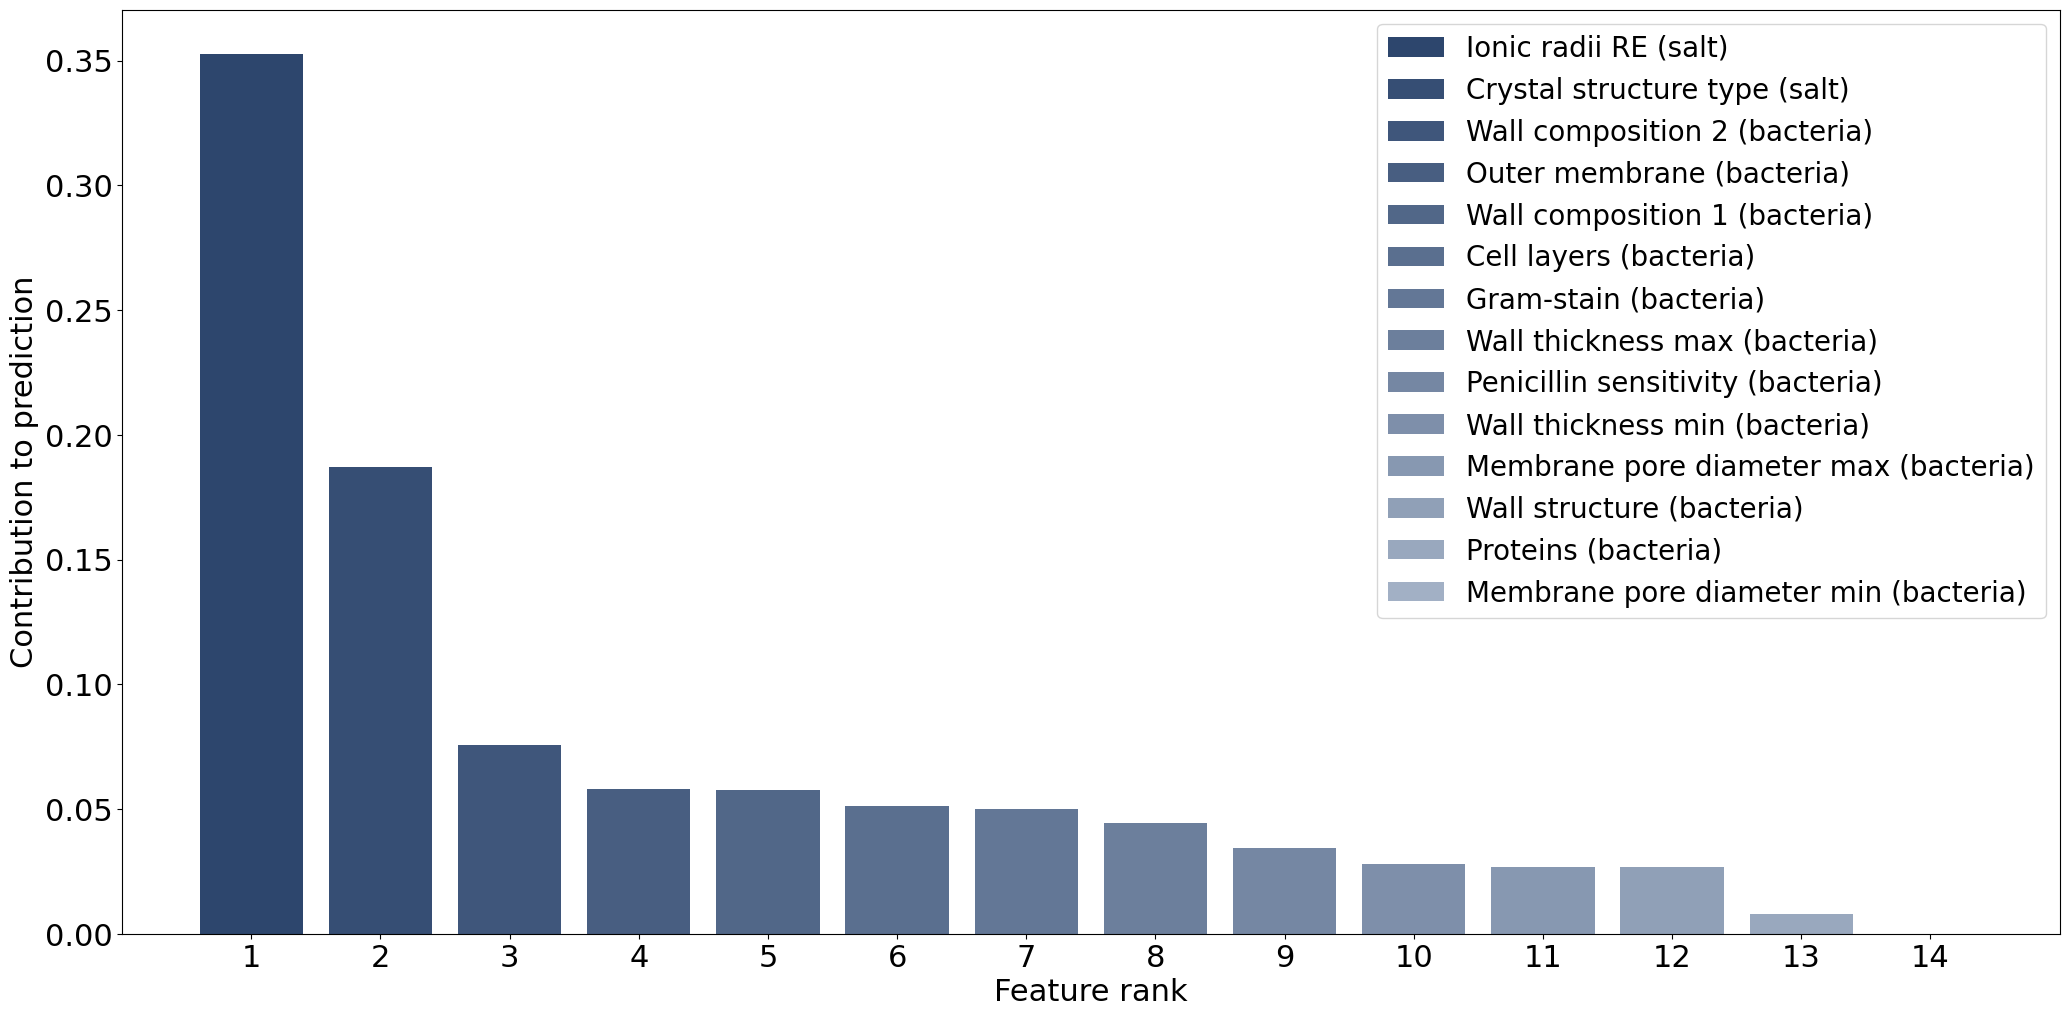

In [35]:
draw_importance(
    best_random_forest_bacterias.feature_importances_, 
    "Random forest bacterias props",
    columns=X.columns,
    is_save=True
)

### Geadient boosting

In [36]:
best_gradient_boost_bacterias, _ = run_gradient_boosting(X, y)

MAE:  4.845031443290173
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 400}
R2:  -0.4471399807323381
MSE:  43.74235019636808
EVS:  0.1873694062144343
MAPE:  -0.14288927338787966


Feature ranking:
1. Crystal structure type (salt) 0.344264 
2. Ionic radii RE (salt) 0.226852 
3. Proteins (bacteria) 0.073303 
4. Membrane pore diameter max (bacteria) 0.051660 
5. Cell layers (bacteria) 0.044901 
6. Outer membrane (bacteria) 0.043416 
7. Wall thickness max (bacteria) 0.043147 
8. Wall structure (bacteria) 0.038129 
9. Wall composition 2 (bacteria) 0.032162 
10. Wall thickness min (bacteria) 0.029635 
11. Penicillin sensitivity (bacteria) 0.029545 
12. Gram-stain (bacteria) 0.023794 
13. Wall composition 1 (bacteria) 0.019192 
14. Membrane pore diameter min (bacteria) 0.000000 


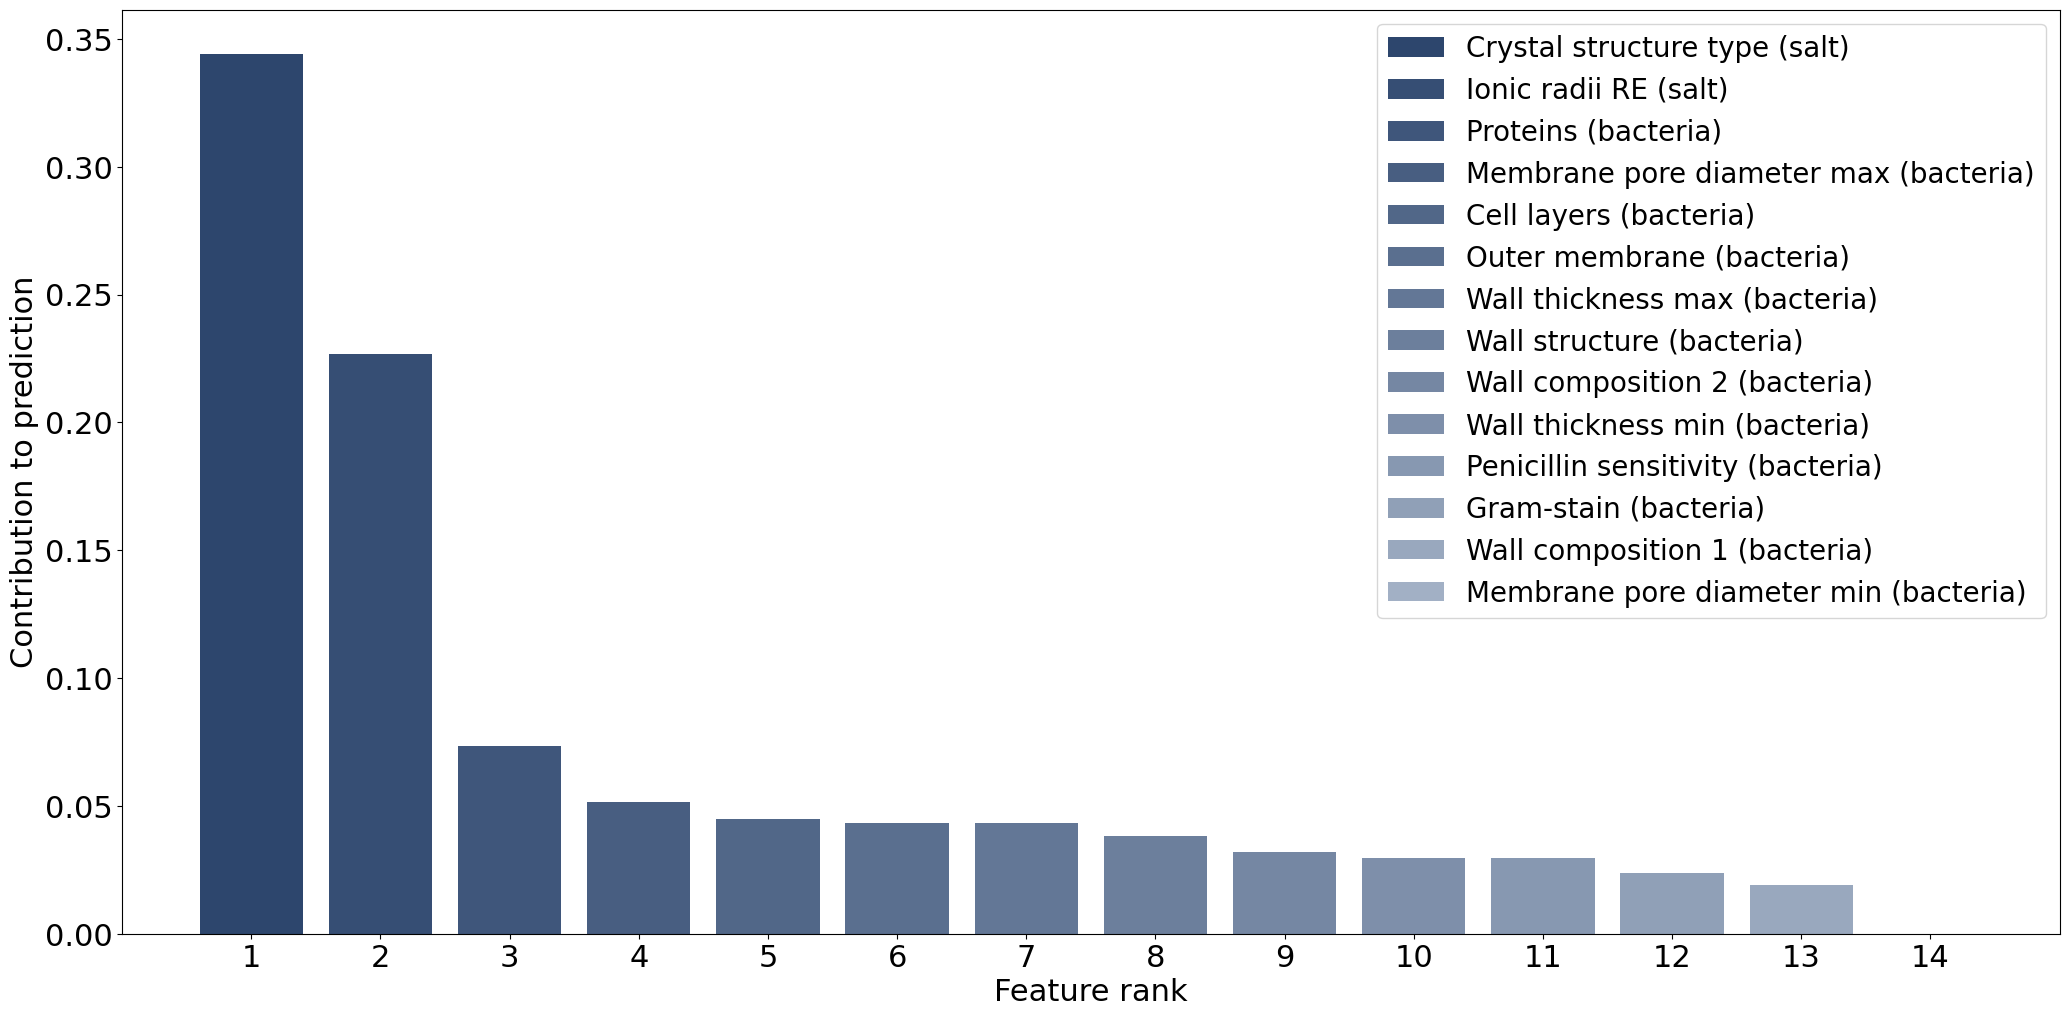

In [37]:
draw_importance(
    best_gradient_boost_bacterias.feature_importances_,
    "Gradient boosting bacterias",
    columns=X.columns,
    is_save=True
)

### XGBoosting

In [38]:
best_xgboost_bacterias, _ = run_xgboost(X, y)

MAE:  4.755251574743363
{'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 1.0}
R2:  -0.45292797907944876
MSE:  43.91588806220134
EVS:  0.16100793723839568
MAPE:  -0.13919764111567723


Feature ranking:
1. Wall thickness max (bacteria) 0.517217 
2. Gram-stain (bacteria) 0.235313 
3. Wall thickness min (bacteria) 0.181907 
4. Crystal structure type (salt) 0.037526 
5. Ionic radii RE (salt) 0.028037 
6. Cell layers (bacteria) 0.000000 
7. Outer membrane (bacteria) 0.000000 
8. Membrane pore diameter min (bacteria) 0.000000 
9. Membrane pore diameter max (bacteria) 0.000000 
10. Proteins (bacteria) 0.000000 
11. Penicillin sensitivity (bacteria) 0.000000 
12. Wall structure (bacteria) 0.000000 
13. Wall composition 2 (bacteria) 0.000000 
14. Wall composition 1 (bacteria) 0.000000 


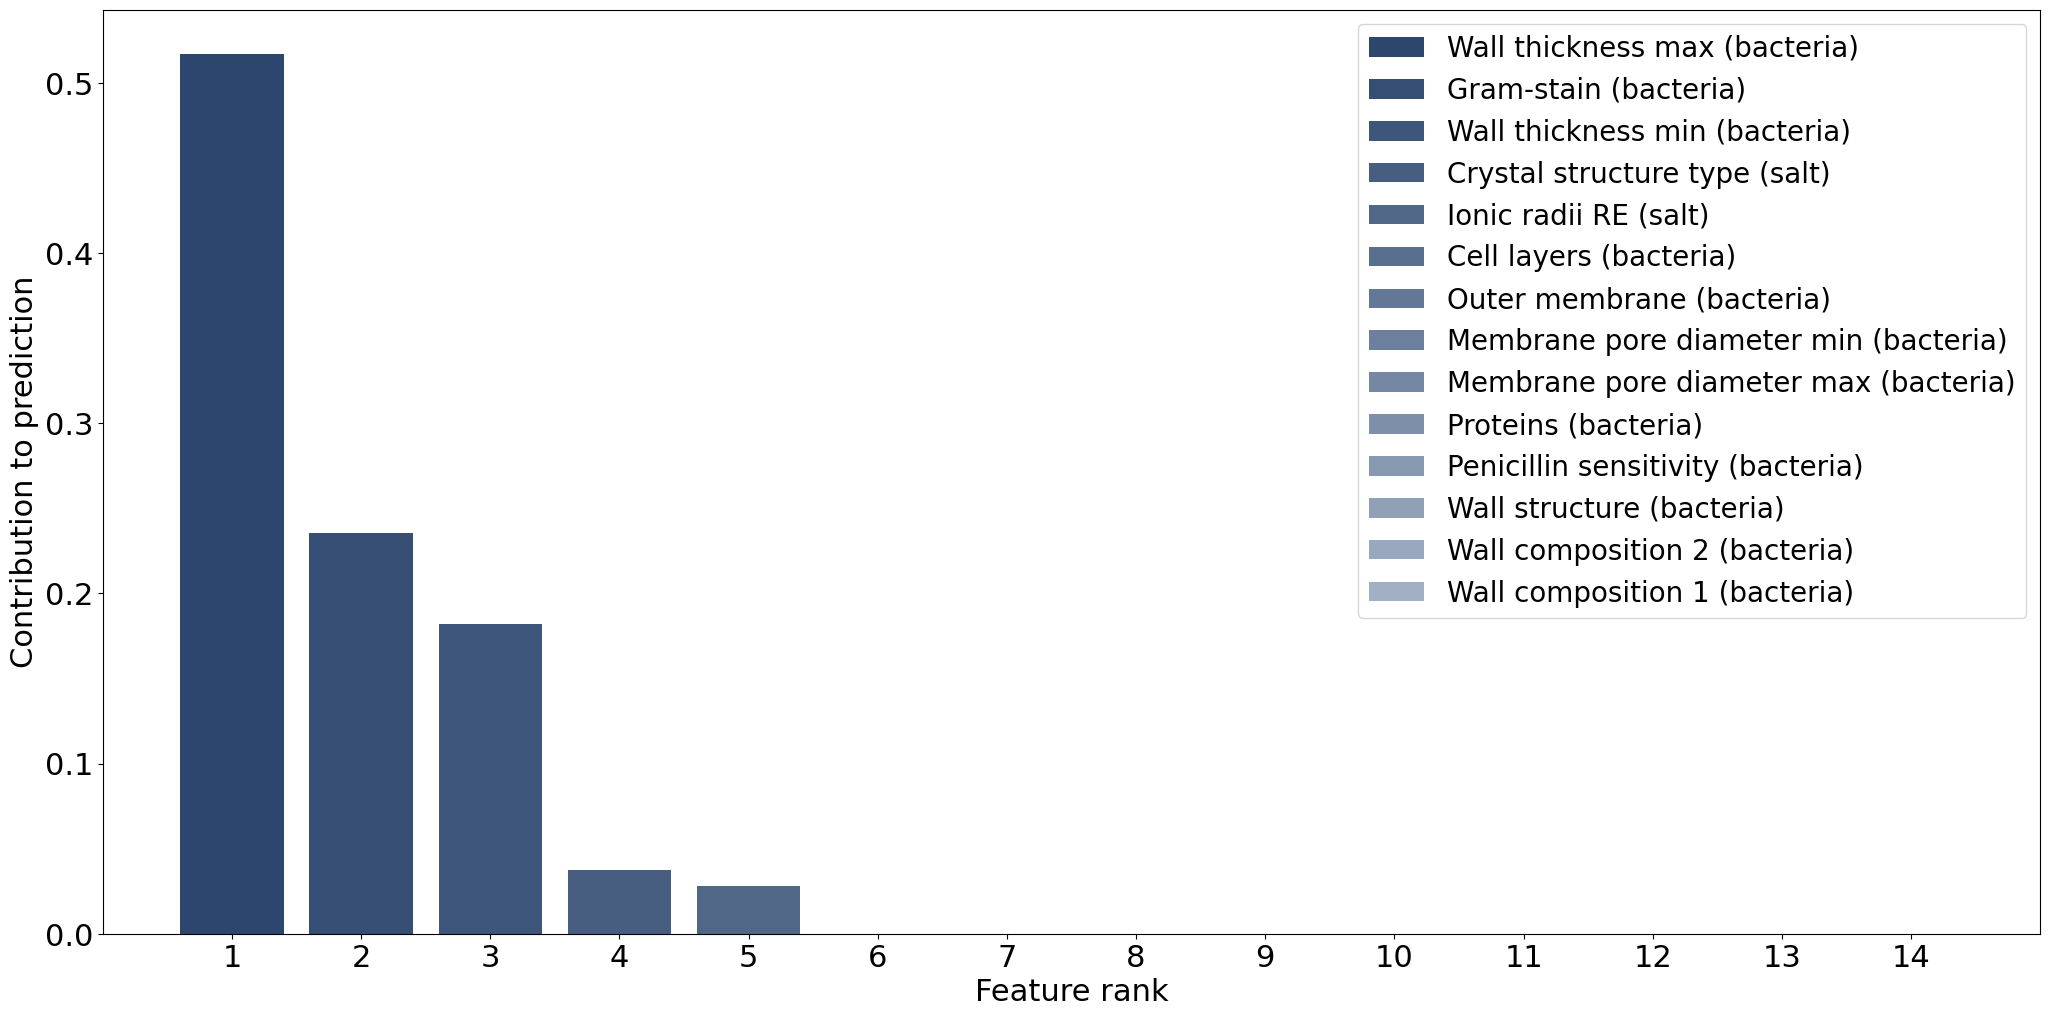

In [39]:
draw_importance(
    best_xgboost_bacterias.feature_importances_, 
    "XGboost bacterias",
    columns=X.columns,
    is_save=True
)

In [ ]:
from itertools import combinations
from tqdm import tqdm

en_col = ['Electronegativity (Oganov)', 'Electronegativity (Malliken)',
                                          'Electronegativity (Paulling)']
scores = {'MAE': [], 'R2': [], 'MSE': [], 'EVS': []}
en_col_combinations = []

for i in range(0, len(en_col) + 1):
    en_col_combinations += list(combinations(en_col, i))

for comb in tqdm(en_col_combinations):
    print(list(comb))
    d = list(comb)
    # if len(d) == 0:
    #     pass
    #     # _, score = run_xgboost(X, y, is_show_params=False)
    # else:
    _, score = run_xgboost(X.drop(d, axis=1), y, is_show_params=False)
    for key in score:
        scores[key] += [score[key]]

  0%|          | 0/8 [00:00<?, ?it/s]

[]


 12%|█▎        | 1/8 [02:29<17:23, 149.04s/it]

MAE:  4.7711864271618065
R2:  -0.45453050529581757
MSE:  44.44503571791581
EVS:  0.18023135438914678
['Electronegativity (Oganov)']


 25%|██▌       | 2/8 [04:54<14:42, 147.09s/it]

MAE:  4.767370045979819
R2:  -0.4342062066360207
MSE:  43.545389944434945
EVS:  0.17720879097736472
['Electronegativity (Malliken)']


 38%|███▊      | 3/8 [07:23<12:18, 147.68s/it]

MAE:  4.795079269409181
R2:  -0.4629108665342968
MSE:  45.04669258102191
EVS:  0.1326552126213088
['Electronegativity (Paulling)']


 50%|█████     | 4/8 [09:52<09:52, 148.18s/it]

MAE:  4.7565721493675595
R2:  -0.44000602686069834
MSE:  44.148502841372746
EVS:  0.18385021667199952
['Electronegativity (Oganov)', 'Electronegativity (Malliken)']


 62%|██████▎   | 5/8 [12:12<07:16, 145.47s/it]

MAE:  4.766303249540782
R2:  -0.4382410618771756
MSE:  44.47547960161758
EVS:  0.11928279575612968
['Electronegativity (Oganov)', 'Electronegativity (Paulling)']


 75%|███████▌  | 6/8 [14:33<04:47, 143.90s/it]

MAE:  4.756426950182234
R2:  -0.4289438084647963
MSE:  44.18493897540924
EVS:  0.19098732990486061
['Electronegativity (Malliken)', 'Electronegativity (Paulling)']


 88%|████████▊ | 7/8 [16:58<02:24, 144.32s/it]

MAE:  4.771501637413388
R2:  -0.4444427870885864
MSE:  45.32140533629011
EVS:  0.14698167258656283
['Electronegativity (Oganov)', 'Electronegativity (Malliken)', 'Electronegativity (Paulling)']


100%|██████████| 8/8 [19:13<00:00, 144.19s/it]

MAE:  4.755251574743363
R2:  -0.45292797907944876
MSE:  43.91588806220134
EVS:  0.16100793723839568


### Salts

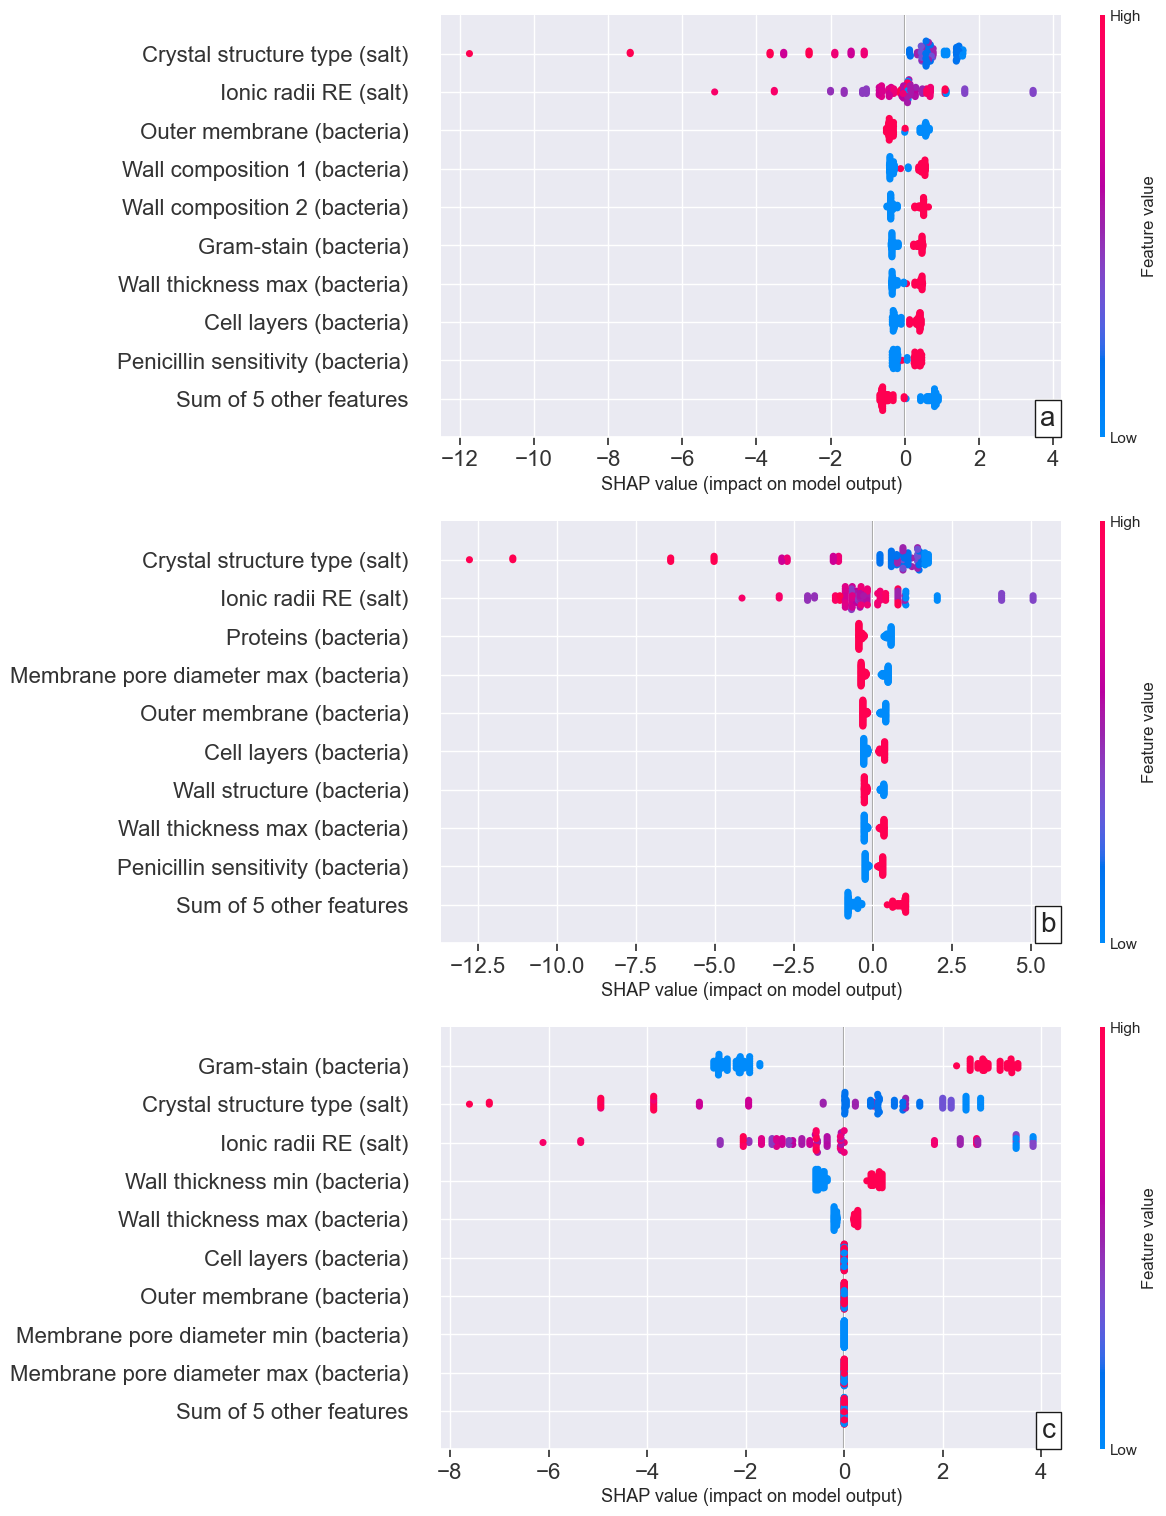

In [162]:
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
y = 0.02
x = 1.03
txt = AnchoredText("a", loc="lower right", pad=0.2, borderpad=0, prop=dict(fontsize="small"))
plt.gca().add_artist(txt)
explain(best_random_forest_bacterias, X, "RandomForest_salts_shap", False, True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 2)
txt = AnchoredText("b", loc="lower right", pad=0.2, borderpad=0, prop=dict(fontsize="small"))
plt.gca().add_artist(txt)
explain(best_gradient_boost_bacterias, X, "GradientBoosting_salts_shap", False, True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 3)
txt = AnchoredText("c", loc="lower right", pad=0.2, borderpad=0, prop=dict(fontsize="small"))
plt.gca().add_artist(txt)
explain(best_xgboost_bacterias, X, "XGBoost_salts_shap", False, True)
plt.subplots_adjust( 
    top=2.5
)
plt.tick_params(axis='both', labelsize=16)
plt.savefig(f'{artifacts_path}Salts_shap.png', bbox_inches='tight')

In [163]:
explainer = shap.Explainer(best_xgboost_bacterias, X)
shap_values = explainer(X)
shap.plots.force(shap_values)

# Bacteria solutions

In [22]:
bacterias_data_solution = df[df['Salt/Solution'] == 0][['Stunting diameter', 'RE-O(H2O) (solution)',
                                         'RE-O(NO3) (solution)',
                                         'Coordination number RE-O(H2O) (solution)', 'Coordination number RE-O(NO3) (solution)', 'Gram-stain (bacteria)',
                                         'Wall thickness min (bacteria)', 'рН (solution)', 'Wall thickness max (bacteria)', 'Wall structure (bacteria)',
                                         'Wall composition 1 (bacteria)', 'Nitrate complexes stability constant (solution)', 'Wall composition 2 (bacteria)', 'Outer membrane (bacteria)',
                                         'Membrane pore diameter min (bacteria)', 'Membrane pore diameter max (bacteria)', 'Proteins (bacteria)',
                                         'Penicillin sensitivity (bacteria)', 'Cell layers (bacteria)']]
bacterias_data_solution = bacterias_data_solution.dropna()

In [23]:
X = bacterias_data_solution.drop('Stunting diameter', axis=1)
y = bacterias_data_solution['Stunting diameter']
X.shape

(39, 18)

#### Learning

In [24]:
best_random_forest_bacterias_solutions, _= run_rforest(X, y)

MAE:  1.8639213009052242
{'max_depth': 1, 'n_estimators': 150}
R2:  -0.28319280161293975
MSE:  6.309041628003209
EVS:  -0.014939175741990685
MAPE:  -0.09250637018907576


In [25]:
best_gradient_boost_bacterias_solution, _ = run_gradient_boosting(X, y)

MAE:  1.796664602008449
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 4}
R2:  -0.14930071753884322
MSE:  5.595281255624381
EVS:  0.10847713752565147
MAPE:  -0.08898924590140944


In [26]:
best_xgboost_bacterias_solution, _ = run_xgboost(X, y)

MAE:  1.8149206978934154
{'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 1.0}
R2:  -0.16841119890432912
MSE:  5.673054812283668
EVS:  0.14518642726942302
MAPE:  -0.08885028717005304


#### Shap

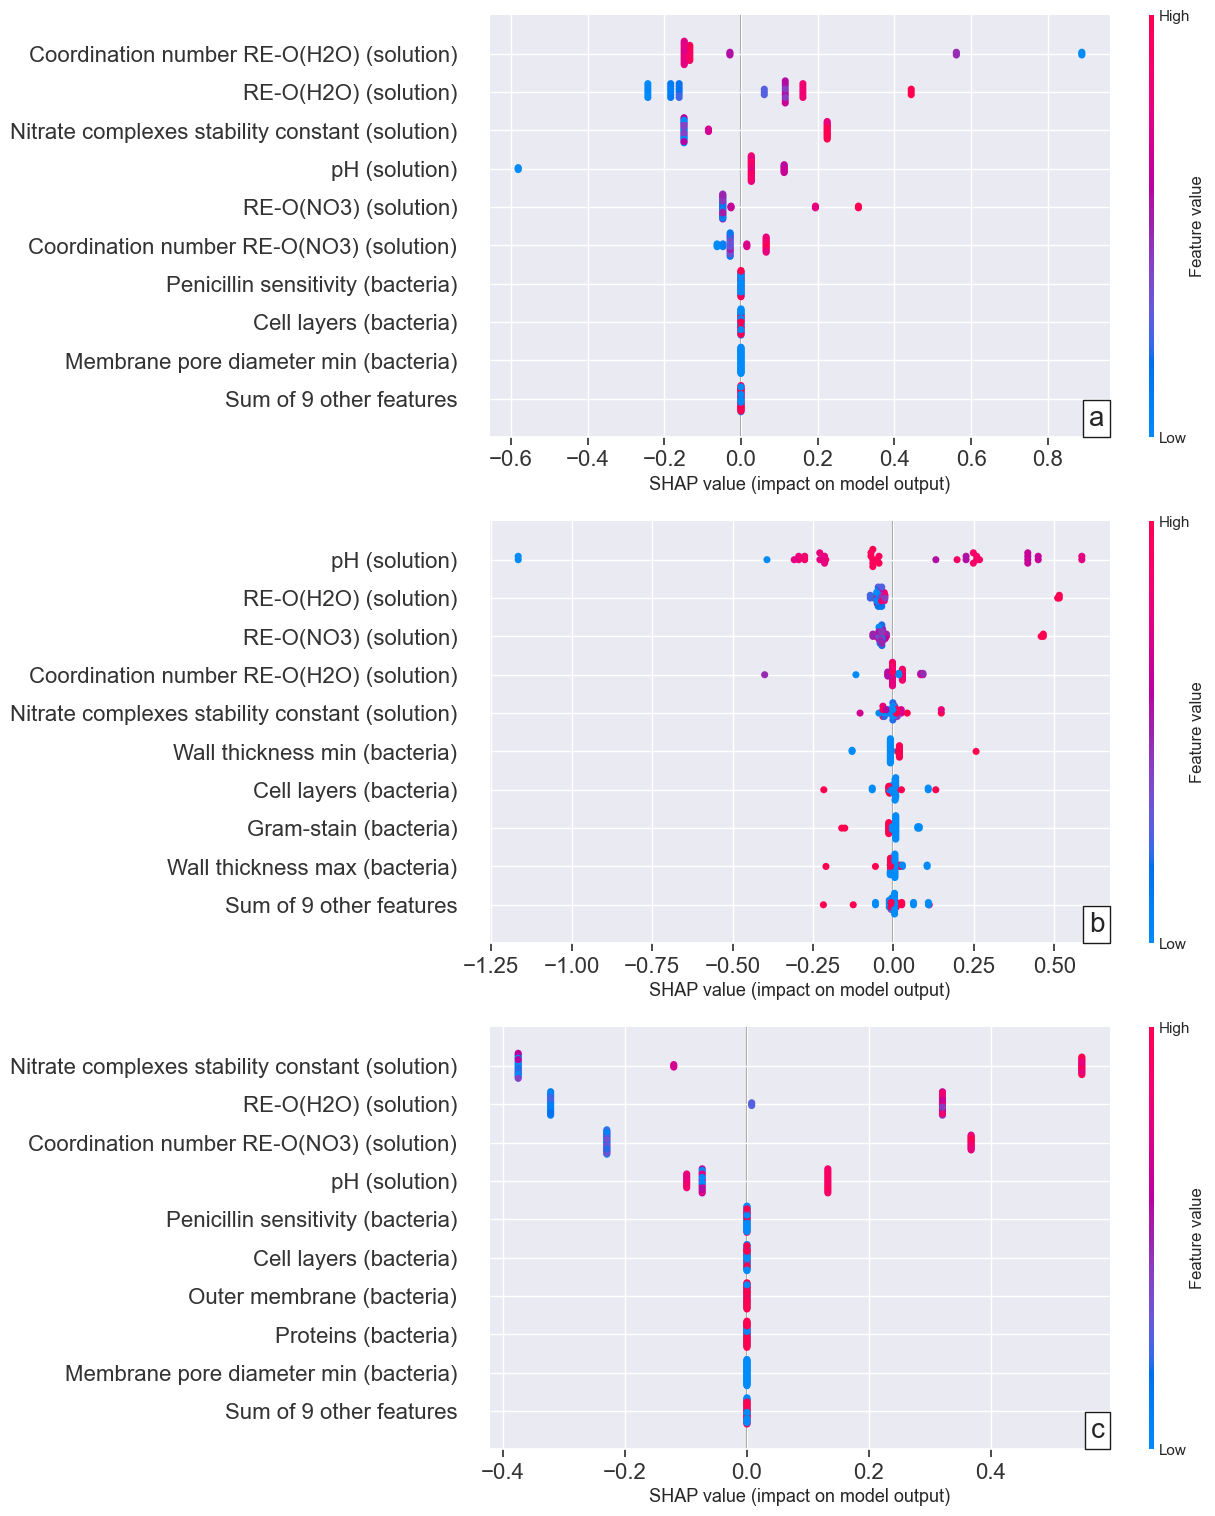

In [159]:
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
y = 0.02
x = 1.03
txt = AnchoredText("a", loc="lower right", pad=0.2, borderpad=0, prop=dict(fontsize="small"))
plt.gca().add_artist(txt)
explain(best_random_forest_bacterias_solutions, X, "RandomForest_solutions_shap", False, True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 2)
txt = AnchoredText("b", loc="lower right", pad=0.2, borderpad=0, prop=dict(fontsize="small"))
plt.gca().add_artist(txt)
explain(best_gradient_boost_bacterias_solution, X, "GradientBoosting_solutions_shap", False, True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 3)
txt = AnchoredText("c", loc="lower right", pad=0.2, borderpad=0, prop=dict(fontsize="small"))
plt.gca().add_artist(txt)
explain(best_xgboost_bacterias_solution, X, "XGBoost_solutions_shap", False, True)
plt.subplots_adjust( 
    top=2.5
)
plt.tick_params(axis='both', labelsize=16)
plt.savefig(f'{artifacts_path}Solutions_shap.png', bbox_inches='tight')

In [132]:
explainer = shap.Explainer(best_xgboost_bacterias_solution, X)
shap_values = explainer(X)
shap.plots.force(shap_values)

In [104]:
df.columns

Index(['REE', 'Bacteria', 'Salt/Solution', 'Stunting diameter',
       'Ionic radii RE (salt)', 'X', 'Electronegativity (Oganov)',
       'Electronegativity (Malliken)', 'Electronegativity (Paulling)',
       'Crystal structure type (salt)', 'RE-O(H2O) (solution)',
       'RE-O(NO3) (solution)', 'Coordination number RE-O(H2O) (solution)',
       'Coordination number RE-O(NO3) (solution)', 'рН (solution)',
       'Nitrate complexes stability constant (solution)',
       'Electronic structure RE3+', 'Price', 'Name', 'Gram-stain (bacteria)',
       'Wall thickness min (bacteria)', 'Wall thickness max (bacteria)',
       'Wall structure (bacteria)', 'Wall composition 1 (bacteria)',
       'Wall composition 2 (bacteria)', 'Outer membrane (bacteria)',
       'Membrane pore diameter min (bacteria)',
       'Membrane pore diameter max (bacteria)', 'Proteins (bacteria)',
       'Penicillin sensitivity (bacteria)', 'Cell layers (bacteria)'],
      dtype='object')